# Custom Classes

## Introduction
Herein, we shall devise custom classes to target extend to scope of B-FADE to other models. In order to show how to readily derive such custom classes shall consider a simple linear model:

$x_2 = m\,x_1 + q,$

which acts as a decision boundary between safe (below) and unsafe (above) classes, i.e. $y_i=0$ and $y_i=1$, respectively. Given a certain dataset $\mathcal{D}$:

$\mathcal{D} = \{((x_{1, i}, x_{2, i}), y_i) : i=1, \dots, N\},$

we wish to infer $m$, and $q$. 

This example is divided into two sections: the first addresses the identification of an ideal noise-free dataset, whereas the second tackles the identification given a noisy dataset. To do so, we shall define a custom class for core computations and plotting utilities and run MAP through B-FADE. The classes can therefore be used in both cases.

Please note that this notebook can directly be imported in Google Colab as stated in the documentation. In this case install B-FADE and mount your Google Drive in the curren workspace.

In [1]:
# !pip install b-fade
# from google.cloud import drive
# drive.mount('/content/drive/')
## access your data through the default path /content/drive/My Drive/Colab Notebooks/YourDataFile.csv

otherwise add the source folder of this package to the Python path. If you did not intend to do the following because you installed the package, skip/comment the cell below.

In [2]:
from sys import path as syspath
from os import path as ospath
syspath.append(ospath.join(ospath.expanduser("~"),
                           '/home/ale/Desktop/b-fade/src'))

Before commencing, let us import all the required modules.

In [3]:
from typing import Any, Dict, List
import numpy as np
import scipy
from scipy.special import expit
from sklearn.metrics import log_loss # Bernoulli likelihood from scikit-learn
from bfade.util import identity,config_matplotlib, logger_manager
from bfade.abstract import AbstractCurve, AbstractBayes
from bfade.dataset import SyntheticDataset
from bfade.viewers import BayesViewer, LaplacePosteriorViewer, PreProViewer
from bfade.statistics import MonteCarlo

## Subclassing

In short, we shall need to new classes: one provide the concrete representation of a line through `AbstractCurve`, the other implements Bayesian Inference from `AbstractBayes`. That's it; let's see how to work this out.

As concerns the implementation of the line, we simply subclass ``Line`` from `AbstractCurve` while concretising the method `equation`as shown below.

In [4]:
class Line(AbstractCurve):

    def __init__(self, metrics: callable = ..., **pars: Dict[str, Any]) -> None:
        super().__init__(metrics, **pars)

    def equation(self, X: np.ndarray) -> np.ndarray:
        return self.m * X + self.q # implementation of line function; returns x_2 as shown above

As concerns Bayesian Inference, let us subclass from `AbstractBayes` while customising `predictor` method. In particular, `predictor` is liable for computing the class given the inputs. In this case, `predictor` computes the signed distance between the input point $(x_1, x_2)$ and the unknown line, and squashes the signed distance through the logistic regression (`expit` from `scipy` module).

In [5]:
class LineBayes(AbstractBayes):

    def __init__(self, *pars: List[str], **args: Dict[str, Any]) -> None:
        super().__init__(*pars, **args)

    def predictor(self, D, *P: Dict[str, float]) -> None:
        all_pars = dict(zip(self.pars, P))
        all_pars.update(self.deterministic)
        l = Line(metrics=identity, **all_pars)
        signed_distance, _, _ = l.signed_distance_to_dataset(D) # compute signed disstanc
        return expit(signed_distance)

We are ready to utilise the developed classes.

## Parametrisation
As shown in the [El Haddad notebook](https://b-fade.readthedocs.io/en/latest/_examples/eh_notebook.html) we shall condense all the parameters below, and recall them later.

As an additional amendment, let's configure the solver which computes signed distance. EH curve requires the lower bound 0 on the x-axis, whereas the line does not.

In [6]:
# Signed distance solver -- update lower bound
from bfade import abstract
abstract.MINIMZER_LO_BOUND = -10e7 #!!!

# Configure logger
logger_level = "DEBUG"
logger_manager(level="DEBUG")

# Configure Matplotlib output. This affect look and feel of the plots (optional)
font_size = 12
font_family = "sans-serif" # remove serif from font
use_latex = False # render fonts through LaTeX compiler
config_matplotlib(font_size=font_size, font_family=font_family, use_latex=use_latex)

# Reference Line
m = -2
q = 3
line_name = "Line-Ref" # name of the instance
x_ref = np.linspace(-10, 10, 100) # x-coordinates for inspection

# Training Dataset
x1_bounds = [-15, 15] # bounds for x_1
x2_bounds = [-10, 10] # bounds for x_2
x1_res = 25 # number of points along x_1
x2_res = 25 # number of points along x_2
data_scale = "linear" # scale for the
x1_noise_std = 1 # std dev of the noise injected into training data for x_1 feature
x2_noise_std = 10 # std dev of the noise injected into training data for x_2 feature

# Pre-inference
m_bounds = [-5, -1]
q_bounds = [2, 7]
m_points = 25 # grid size along m
q_points = 25 # grid size along m

# Inference -- Configure LineBayes
# since we know the reference curve, inject prior around the expected parameter
# this can be changed in case of different scenarios/prior knowledge
mean_m = -2 # mean for m
std_m = 1 # std for m
mean_q = 3 # mean q
std_q = 1 # std for q
guess = [-1, 1]

# Post-Inference -- Configure LaplacePosteriorViewer
m_n_std = 4 # number of std dev over which the m posterior is plotted
m_n_points = 100 # number of points for m posterior
q_n_std = 4 # number of std dev over which the q posterior is plotted
q_n_points = 100 # number of points for q posterior

# Post-Inference -- Prediction bands (frequentist crack propagation region)
confidence_level = 95
monte_carlo_samples = 10000
monte_carlo_sampling = "joint" # choose whether sampling joint or marginal posterior

# Post-Inference -- Predictive posterior (Bayesian crack propagation region)
x1_bounds_post = [-15, 15]  # bounds of x1
x2_bounds_post = [-10, 10]  # bounds of x2 
x1_points_post = 30 # grid points of x1
x2_points_post = 30 # grid points of x2
post_grid_spacing = data_scale
posterior_samples = 50 # how many sample to draw from the posterior
post_op_1 = np.mean # function (numpy) to compute mean upon posterior samples
post_op_2 = np.std # function (numpy) to compute mean upon posterior samples

# Post-inference -- Results, PreProViewer
line_res_points = 1000 # resolution of plotted curves along x-axis

Let us instantiate a reference curve for later use. Please note that `identity` is required as we shall compute the signed distances over the linear-linear plane.

In [7]:
l = Line(metrics=identity, m=-2, q=3)
print(l) # output of the dunder method __repr__; overview

Line(name = Untitled,
 metrics = <function identity at 0x7f8c0f918dc0>,
 m = -2,
 q = 3,
 pars = ['m', 'q'],
 save = False,
 folder = ./,
 fmt = png,
 dpi = 300)


## Noise-free Example
### Dataset
We shall generate a dataset consisting of a regular linearly spaced grid having bounds `x1_bounds` and `x2_bounds` with 25 points along both directions; see above.

19:45:14 - bfade.dataset - DEBUG - SyntheticDataset.config
19:45:14 - bfade.dataset - DEBUG - SyntheticDataset.make_grid
19:45:14 - bfade.dataset - DEBUG - SyntheticDataset.make_classes
19:45:14 - bfade.dataset - DEBUG - SyntheticDataset.inspect
19:45:14 - bfade.util - DEBUG - SHOW PIC: NoiseFreeDataset_data


[[-15.   -10.  ]
 [-13.75 -10.  ]
 [-12.5  -10.  ]
 ...
 [ 12.5   10.  ]
 [ 13.75  10.  ]
 [ 15.    10.  ]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 

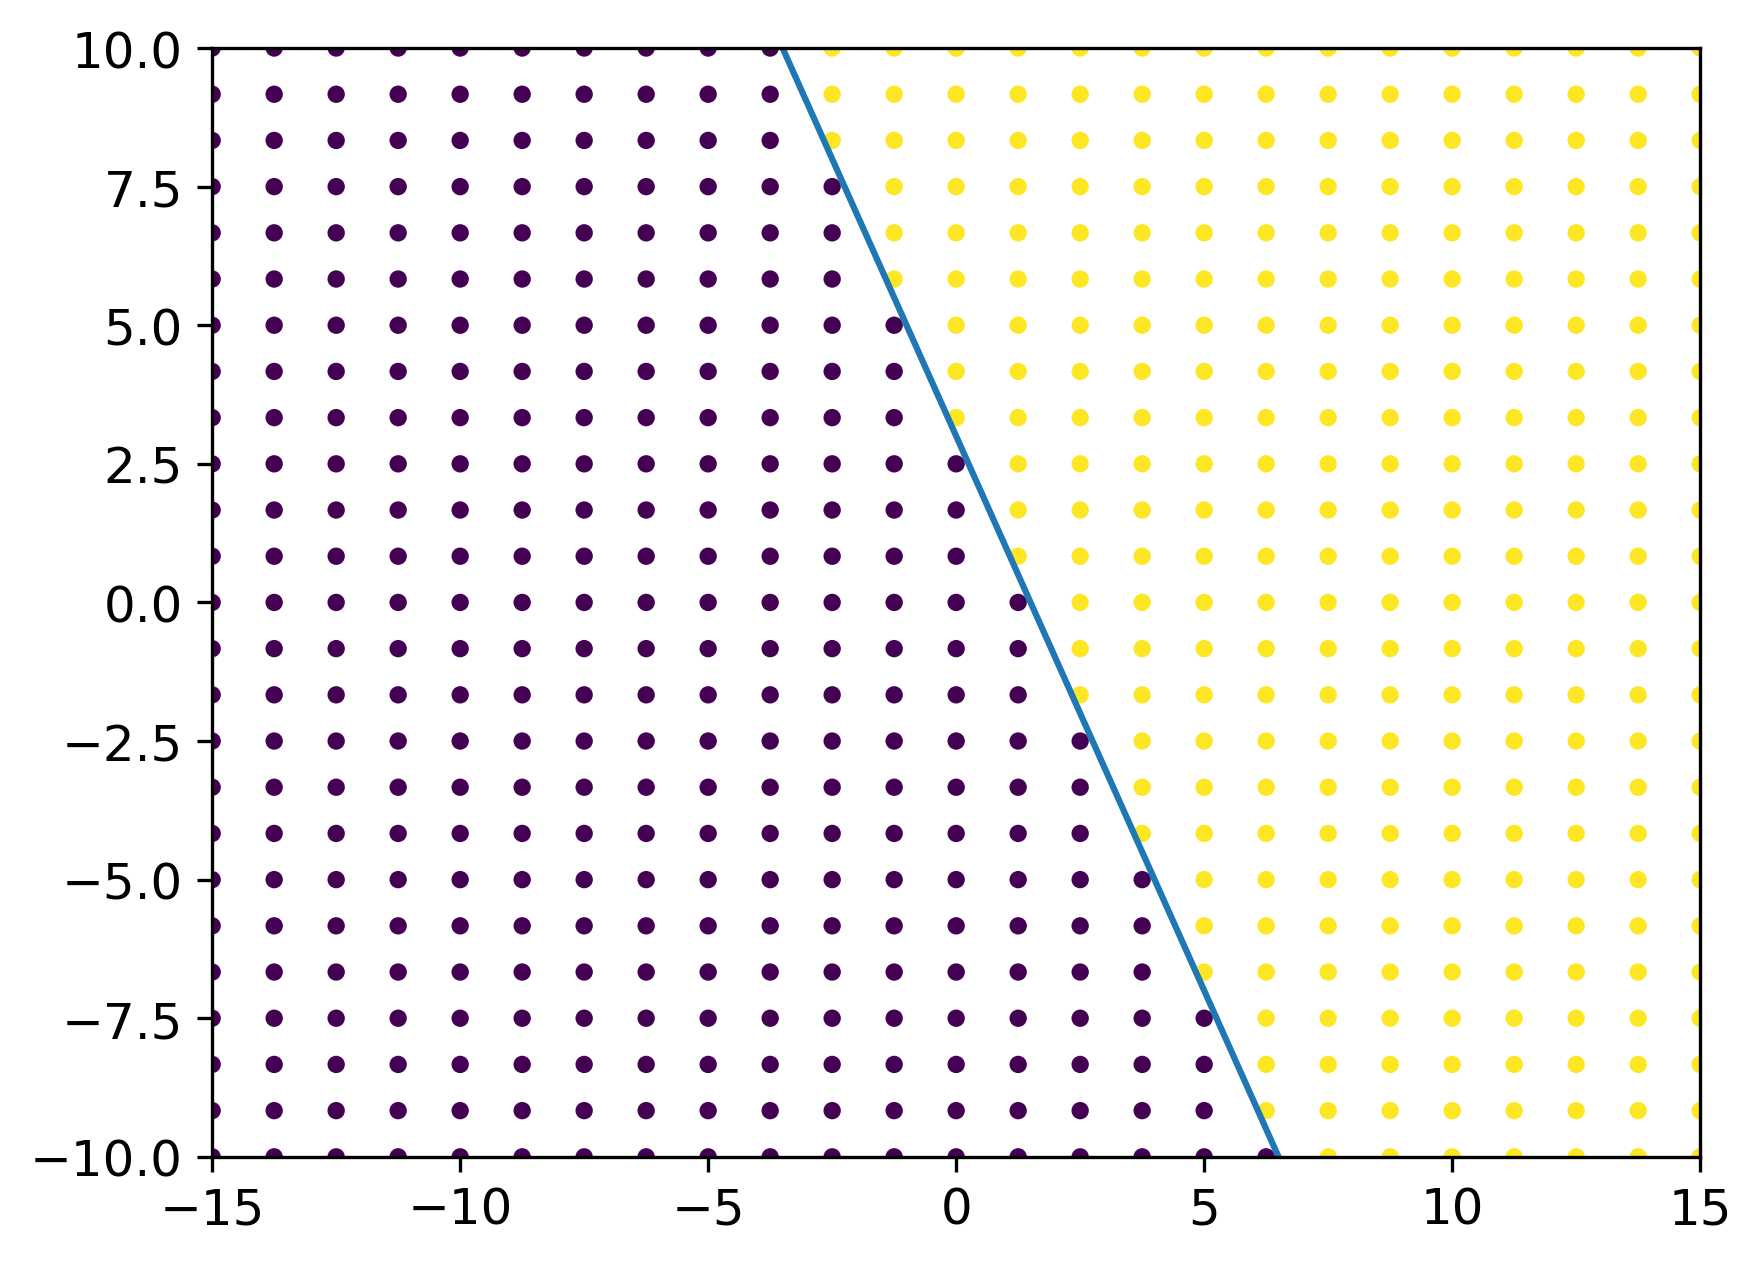

In [8]:
fd = SyntheticDataset(name="NoiseFreeDataset")
fd.make_grid(x1_bounds, x2_bounds, n1=x1_res, n2=x2_res)
fd.make_classes(l) # make classes 0, 1 according to the target line
print(fd.X) # input data: x_1, x_2
print(fd.y) # output classes: 0, 1
fd.inspect(x1_bounds, x2_bounds, scale=data_scale, curve=l, x=x_ref)

### Maximum Likelihood Estimation (MLE)
First, we inspect the likelihood only since we are doing (MLE); no prior knowledge injected. The we run MLE (through MAP command)

In [9]:
# Initialise Bayes infrastructure
fbay = LineBayes("m", "q", name=line_name)
fbay.load_log_likelihood(log_loss, normalize=False)

19:45:14 - bfade.statistics - INFO - (Non-scipy). uniform.__init__
19:45:14 - bfade.statistics - INFO - (Non-scipy). uniform.__init__
19:45:14 - bfade.abstract - DEBUG - LineBayes.__init__ -- LineBayes({'name': 'Line-Ref', 'pars': ('m', 'q'), 'prior_m': <bfade.statistics.Distribution object at 0x7f8c0f31a730>, 'prior_q': <bfade.statistics.Distribution object at 0x7f8c88339940>})
19:45:14 - bfade.abstract - WARNING - LineBayes.MAP -- Optimal values unknown. Must run MAP.
19:45:14 - bfade.abstract - INFO - LineBayes.__init__ -- Deterministic parameter(s) {}
19:45:14 - bfade.abstract - INFO - LineBayes.load_log_likelihood -- <function log_loss at 0x7f8c116bde50>


19:45:14 - bfade.abstract - DEBUG - BayesViewer.__init__ -- BayesViewer(name = Line-Ref,
 pars = ('m', 'q'),
 p1 = m,
 p2 = q,
 n1 = 25,
 n2 = 25,
 b1 = [-5, -1],
 b2 = [2, 7],
 spacing = lin,
 bounds_m = [-5, -1],
 bounds_q = [2, 7])
19:45:14 - bfade.abstract - DEBUG - BayesViewer.config
19:45:14 - bfade.abstract - DEBUG - BayesViewer.config_contour
19:45:14 - bfade.abstract - DEBUG - BayesViewer.config_contour
19:45:14 - bfade.viewers - DEBUG - BayesViewer.contour. Contour: log_likelihood
19:47:59 - bfade.util - DEBUG - SHOW PIC: Line-Ref_bay_log_likelihood


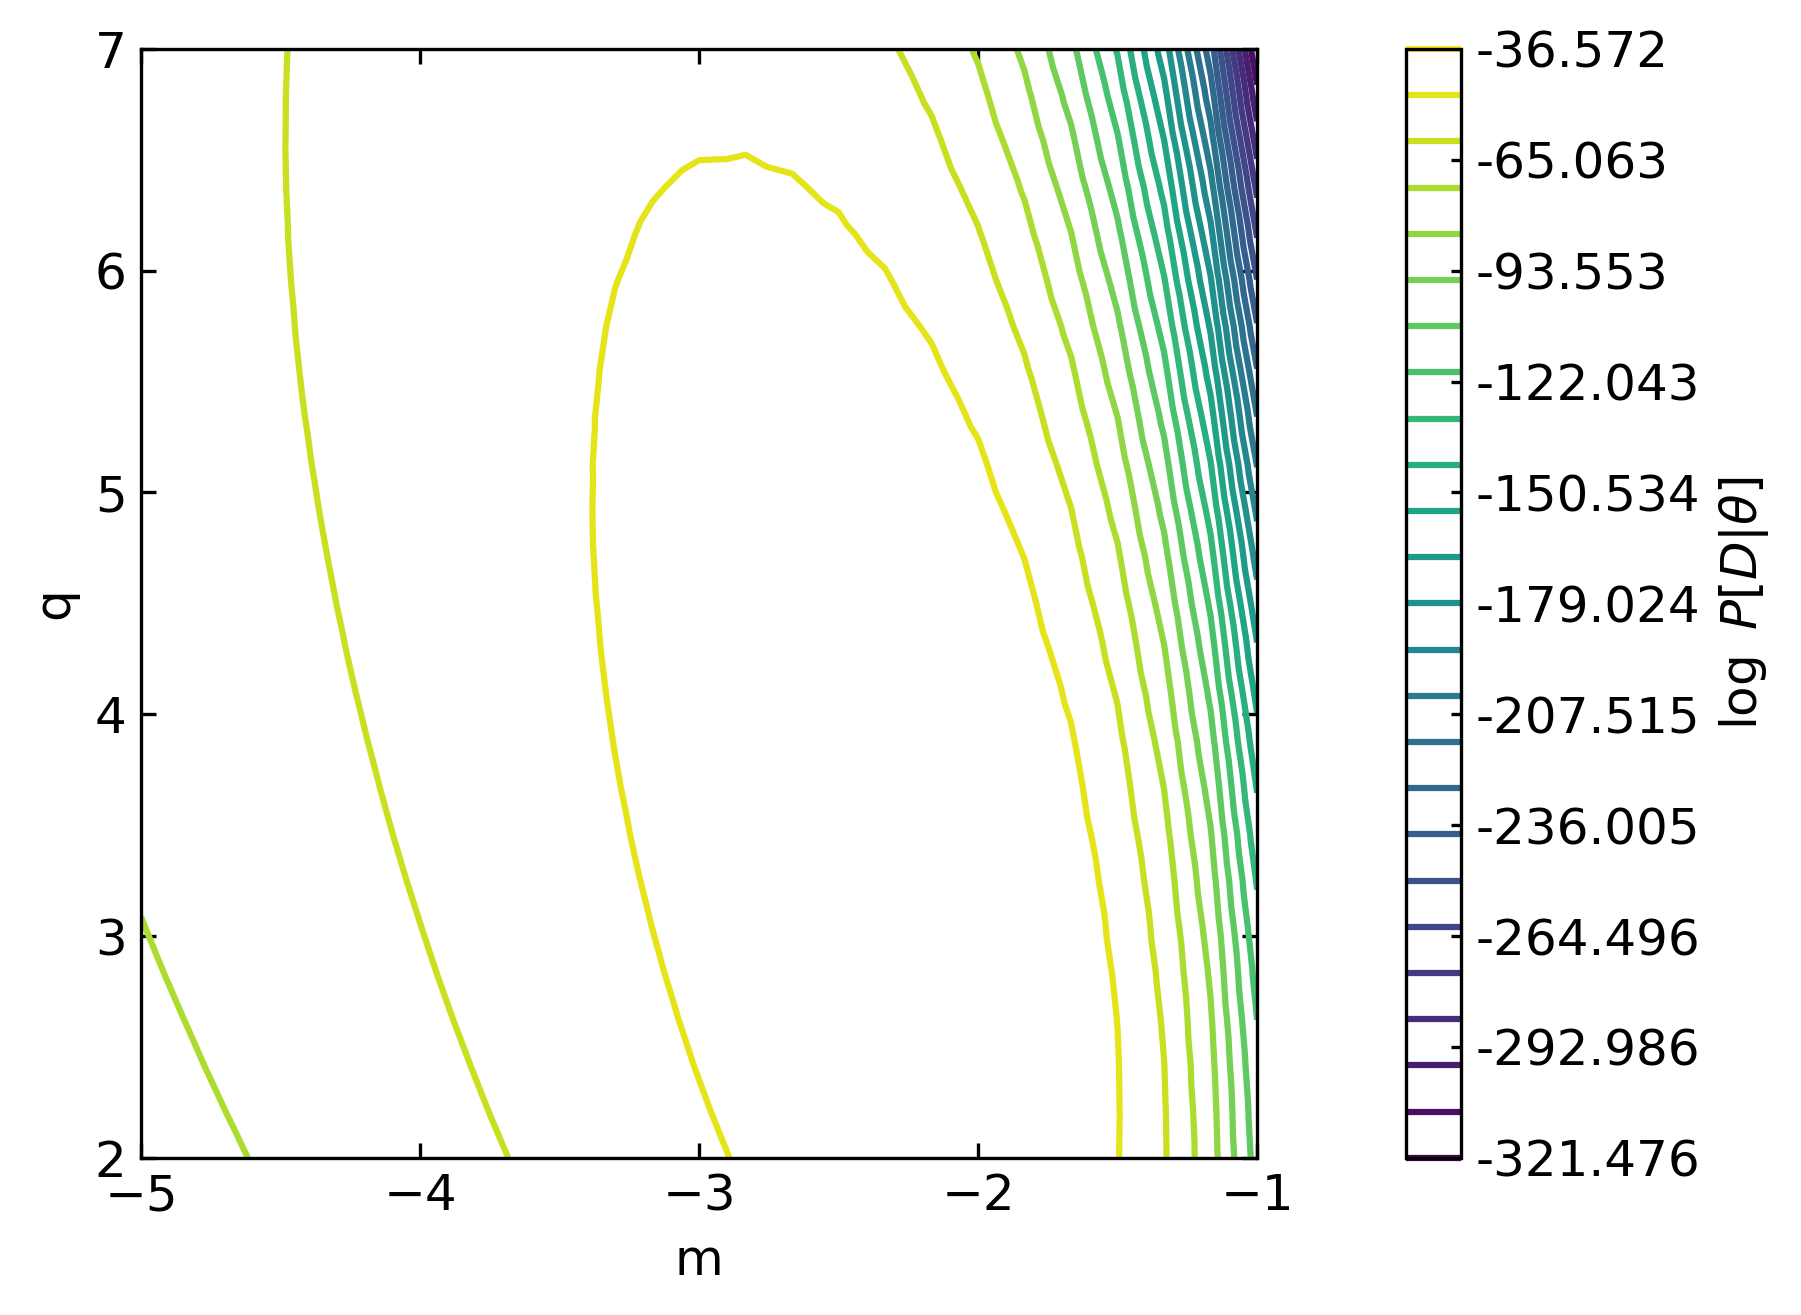

In [10]:
# Initialise BayesViewer and pre-inference inspection
fv = BayesViewer("m", m_bounds, m_points,
                 "q", q_bounds, q_points, name=line_name)
fv.config_contour(levels=25)
fv.contour("log_likelihood", fbay, fd)

We are expecting the solver to converge around $m=-2$, and $q=3$. Then, run MLE (through MAP).

In [11]:
fbay.MAP(fd, guess)

19:47:59 - bfade.abstract - INFO - LineBayes.MAP -- Default solver Nelder-Mead, {'disp': True, 'maxiter': 10000000000.0}
19:47:59 - bfade.abstract - WARNING - LineBayes.MAP -- Run MAP.
19:48:01 - bfade.abstract - INFO - Iter: 0 -- Params: [-1.075  1.075] -- Min 95.723
19:48:01 - bfade.abstract - INFO - Iter: 1 -- Params: [-1.1875  1.0125] -- Min 78.472
19:48:02 - bfade.abstract - INFO - Iter: 2 -- Params: [-1.29375  1.13125] -- Min 65.850
19:48:03 - bfade.abstract - INFO - Iter: 3 -- Params: [-1.571875  1.065625] -- Min 50.023
19:48:04 - bfade.abstract - INFO - Iter: 4 -- Params: [-1.9234375  1.2703125] -- Min 43.002
19:48:04 - bfade.abstract - INFO - Iter: 5 -- Params: [-1.9234375  1.2703125] -- Min 43.002
19:48:05 - bfade.abstract - INFO - Iter: 6 -- Params: [-1.9234375  1.2703125] -- Min 43.002
19:48:06 - bfade.abstract - INFO - Iter: 7 -- Params: [-1.9234375  1.2703125] -- Min 43.002
19:48:06 - bfade.abstract - INFO - Iter: 8 -- Params: [-1.9234375  1.2703125] -- Min 43.002
19:48:0

Optimization terminated successfully.
         Current function value: 36.486246
         Iterations: 48
         Function evaluations: 88


19:49:08 - bfade.abstract - DEBUG - LineBayes.laplace_posterior -- Load distributions.
19:49:08 - bfade.abstract - WARNING - LineBayes.MAP -- theta_hat [-2.09741555  3.09376574]
19:49:08 - bfade.abstract - WARNING - LineBayes.MAP -- ihess [[ 0.02816976 -0.04154757]
 [-0.04154757  0.30496391]]


### Results
Our MLE estimates is pretty close to the reference values. Therefore, we shall extract the estimated (optimal) parameters from and define the expected (optimal) line that partition the dataset. Next, we instantiate a `PreProViewer` to inspect the results, along with the training dataset. MLE, however, does not allow for computing the predictive posterior, and prediction bands.

19:49:08 - bfade.viewers - DEBUG - PreProViewer.__init__ -- PreProViewer(x_edges = [-15, 15],
 y_edges = [-10, 10],
 x_scale = linear,
 y_scale = linear,
 n = 1000,
 name = Line-Ref,
 det_pars = {})
19:49:08 - bfade.viewers - DEBUG - PreProViewer.config
19:49:08 - bfade.viewers - DEBUG - PreProViewer.config_canvas
19:49:08 - bfade.viewers - INFO - Inspect training data
19:49:08 - bfade.viewers - DEBUG - PreProViewer.add_colourbar
19:49:08 - bfade.viewers - DEBUG - State: Line-Ref_train
19:49:08 - bfade.viewers - INFO - Inspect given curves
19:49:08 - bfade.viewers - DEBUG - State: Line-Ref_train_Untitled
19:49:08 - bfade.viewers - DEBUG - State: Line-Ref_train_Untitled_Line-Ref-Estimated
19:49:08 - bfade.viewers - INFO - PreProViewer.view. Legend Setting 'best'
19:49:08 - bfade.util - DEBUG - SHOW PIC: Line-Ref_train_Untitled_Line-Ref-Estimated


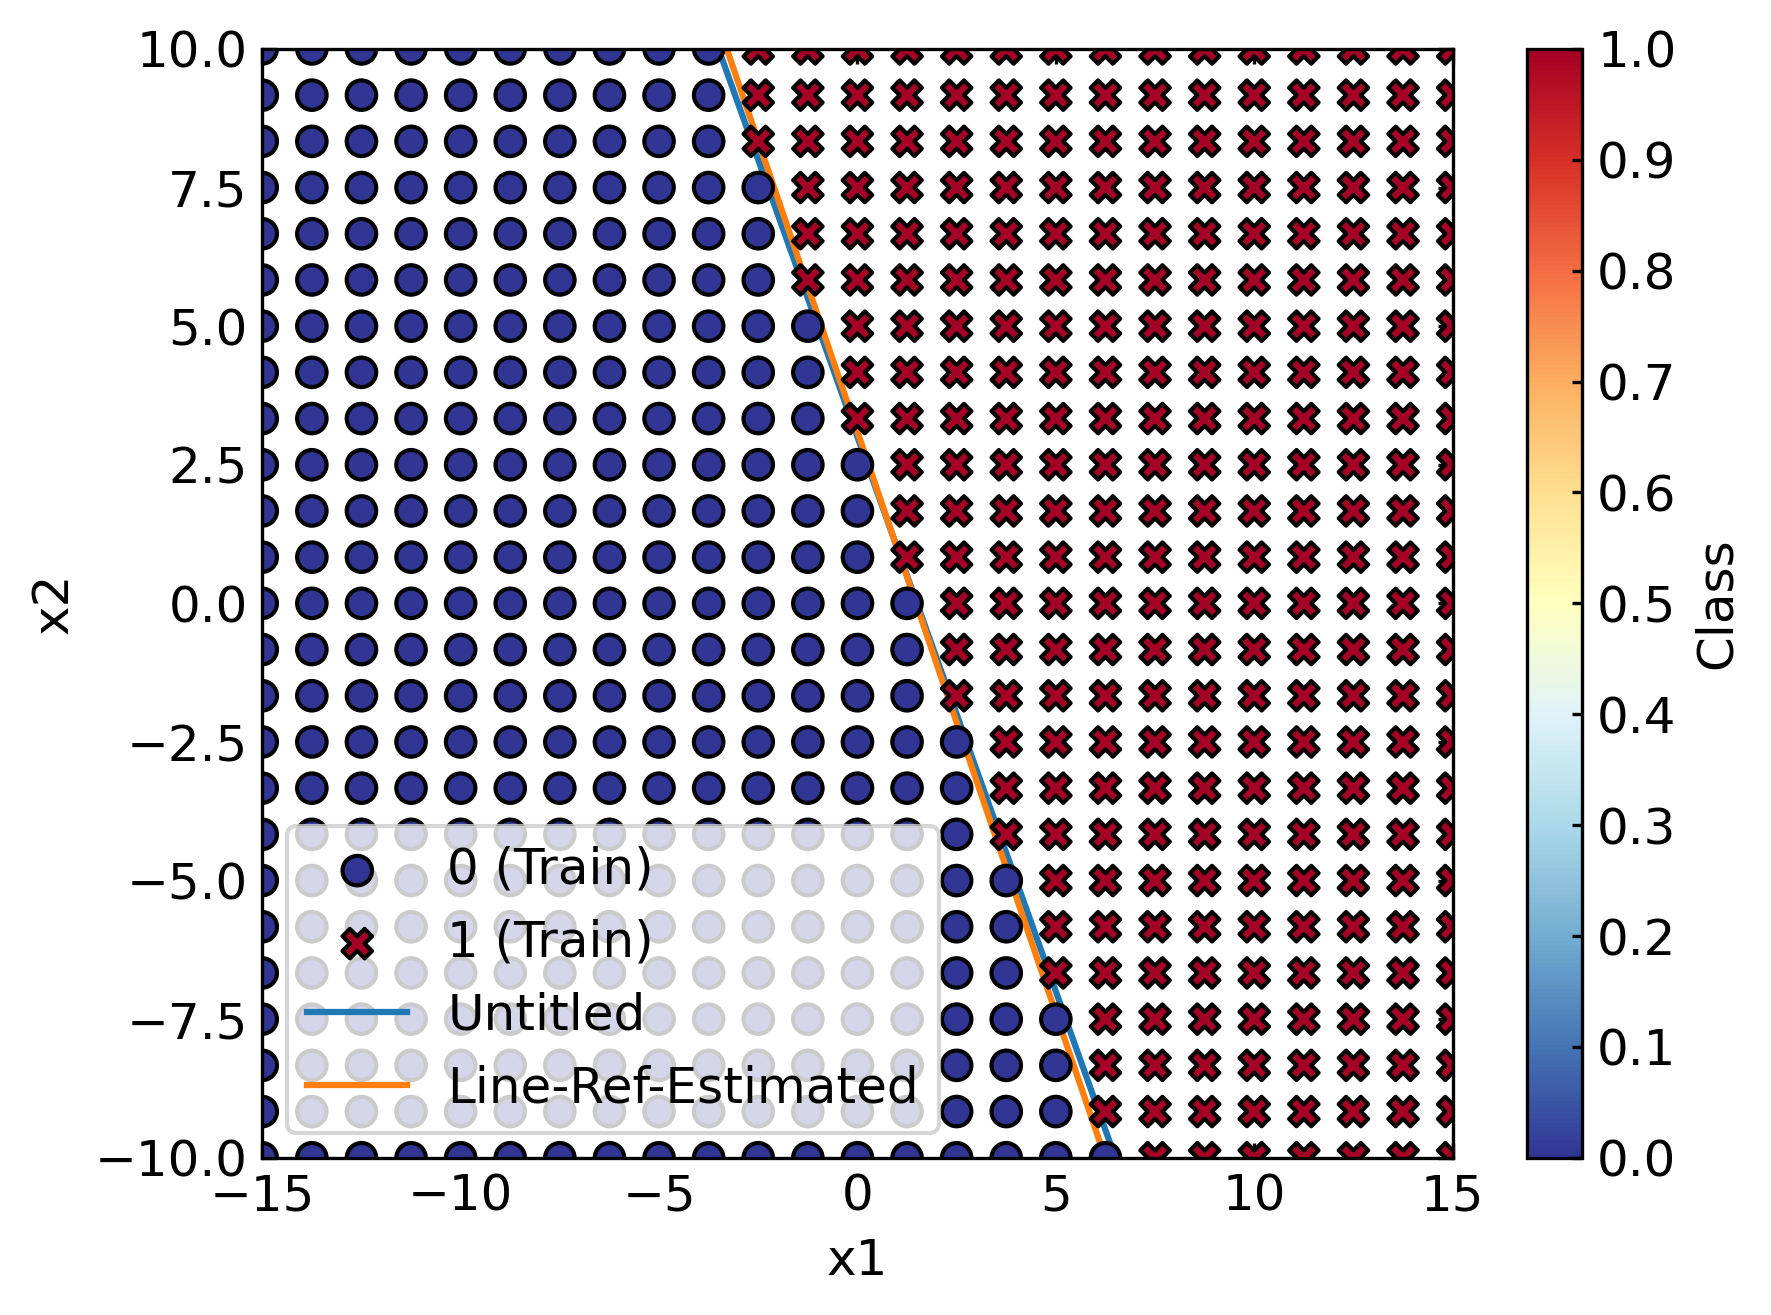

In [12]:
# Retrieve the estimated EH curve through MLE (MAP)
optf = Line(m=fbay.theta_hat[0], q=fbay.theta_hat[1], name=line_name + "-Estimated")

# Instantiate a Viewer
ppf = PreProViewer(x1_bounds, x2_bounds, line_res_points, scale=data_scale, name=line_name)

# Inspect available results and training dataset
ppf.view(train_data=fd, curve=[l, optf])

## Noisy Example
### Dataset
In this example we shall repeat the previous steps in order to generate the dataset, but we inject noise into training data after making classes. Specifically, we inject zero-mean Gaussian noise with different standard deviations for each input feature.

19:49:08 - bfade.dataset - DEBUG - SyntheticDataset.config
19:49:08 - bfade.dataset - DEBUG - SyntheticDataset.make_grid
19:49:08 - bfade.dataset - DEBUG - SyntheticDataset.make_classes
19:49:08 - bfade.dataset - DEBUG - SyntheticDataset.add_noise
19:49:08 - bfade.dataset - DEBUG - SyntheticDataset.inspect
19:49:08 - bfade.util - DEBUG - SHOW PIC: NoisyDataset_data


[[-13.23594765 -22.26196192]
 [-13.34984279  -8.16660801]
 [-11.52126202   6.70943033]
 ...
 [ 12.27574107   6.24777599]
 [ 13.44775027   7.08358014]
 [ 14.62485288  -7.41022808]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0

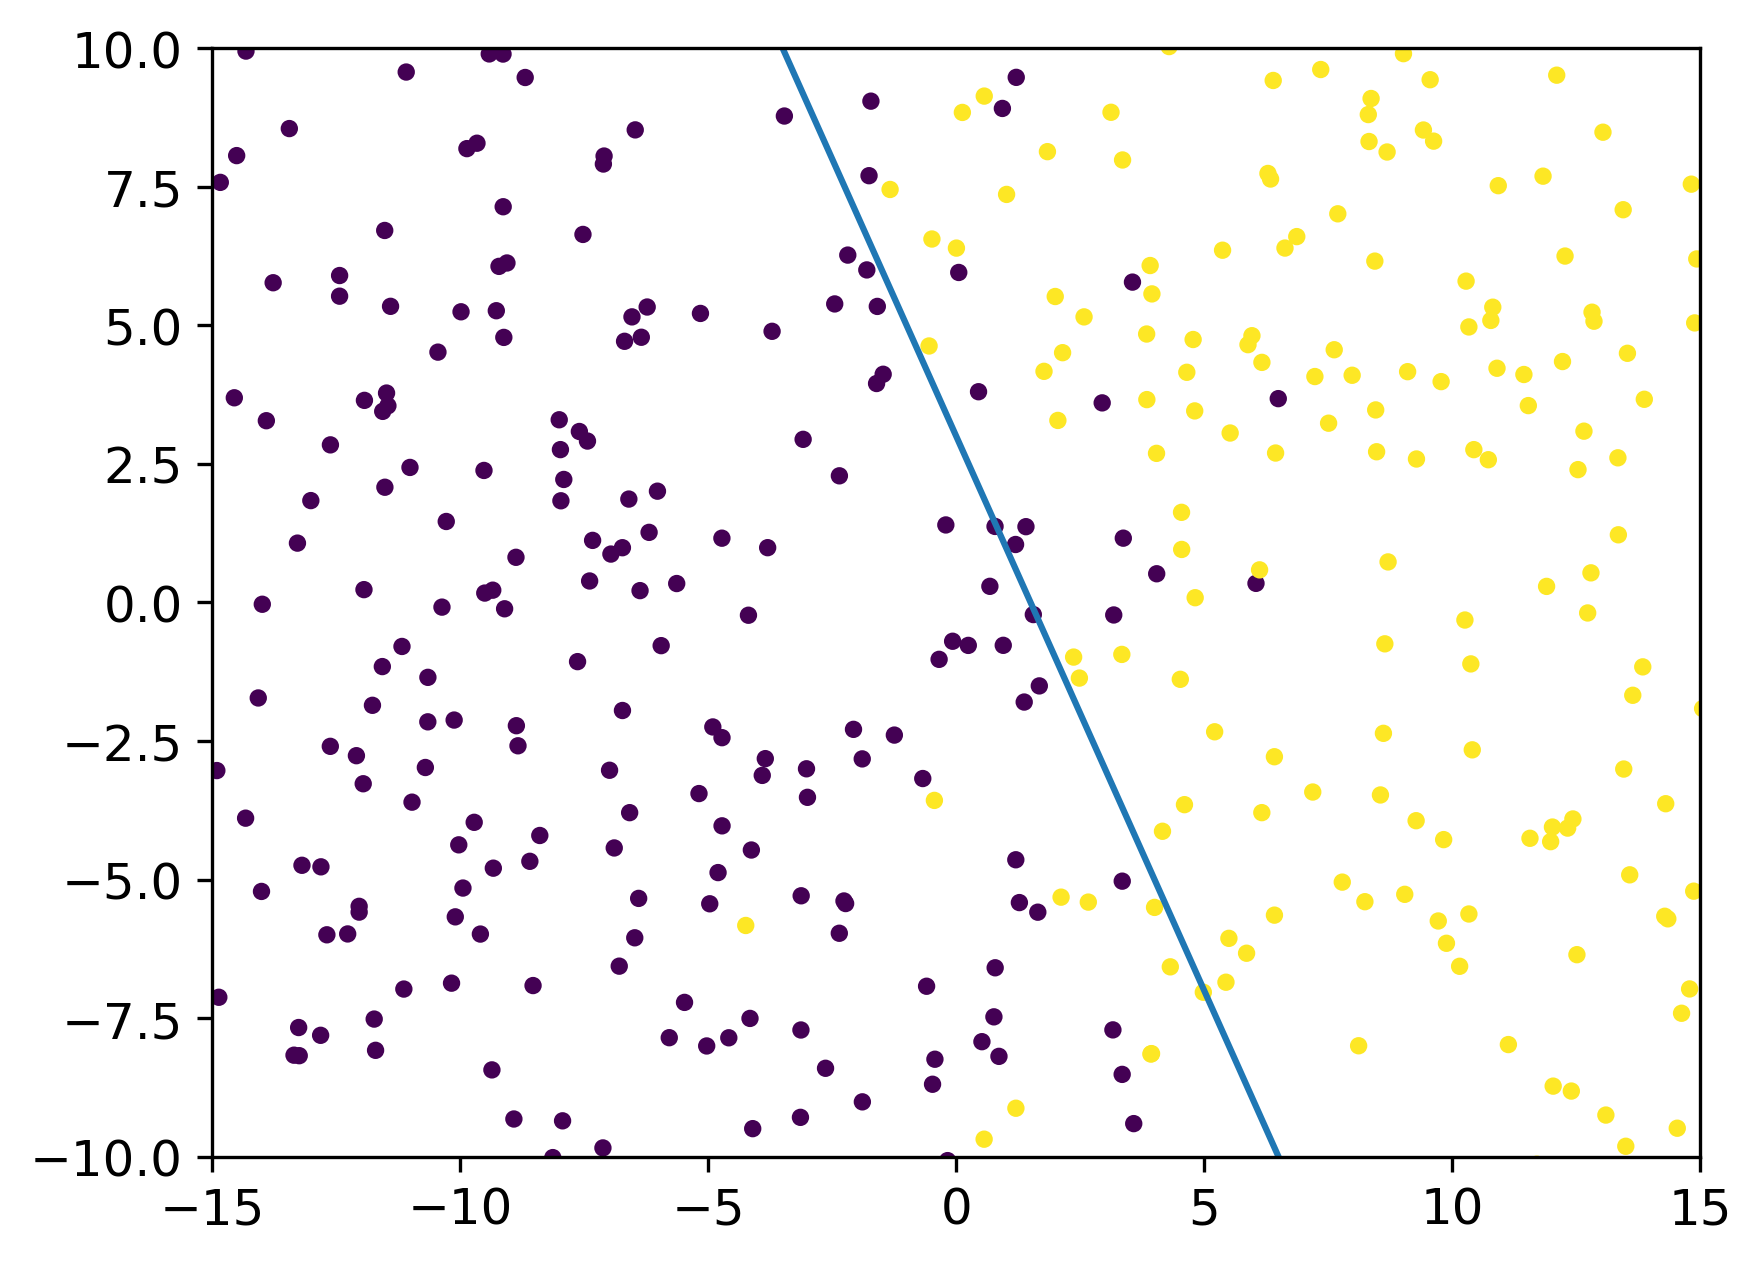

In [13]:
nd = SyntheticDataset(name="NoisyDataset")
nd.make_grid(x1_bounds, x2_bounds, n1=x1_res, n2=x2_res)
nd.make_classes(l) # make classes 0, 1 according to the target line
nd.add_noise(x1_std=x1_noise_std, x2_std=x2_noise_std)
print(nd.X) # input data: x_1, x_2
print(nd.y) # output classes: 0, 1
nd.inspect(x1_bounds, x2_bounds, scale=data_scale, curve=l, x=x_ref) # optional inspection

### Maximum a Posterior (MAP)
In this case we wish to perform MAP, so we need to configure the Bayesian infrastructure with priors. Priors for $m$ and $q$ have mean equal to the reference parameters (since we know them, for the sake of the example), and relatively large standard deviation. Initially, we initialise the Bayesian infrastructure (`LineBayes`). Next, the inspection of Bayes' elements (log-prior, -likelihood, and -posterior) is done. Finally MAP is executed.

In [14]:
# Bayesian infrastructure
nbay = LineBayes("m", "q", name="LineNoiseBayes")
nbay.load_log_likelihood(log_loss_fn=log_loss, normalize=True)
nbay.load_prior("m", scipy.stats.norm, loc=mean_m, scale=std_m)
nbay.load_prior("q", scipy.stats.norm, loc=mean_q, scale=std_q)

19:49:08 - bfade.statistics - INFO - (Non-scipy). uniform.__init__
19:49:08 - bfade.statistics - INFO - (Non-scipy). uniform.__init__
19:49:08 - bfade.abstract - DEBUG - LineBayes.__init__ -- LineBayes({'name': 'LineNoiseBayes', 'pars': ('m', 'q'), 'prior_m': <bfade.statistics.Distribution object at 0x7f8c0a93b760>, 'prior_q': <bfade.statistics.Distribution object at 0x7f8c0aa16910>})
19:49:08 - bfade.abstract - WARNING - LineBayes.MAP -- Optimal values unknown. Must run MAP.
19:49:08 - bfade.abstract - INFO - LineBayes.__init__ -- Deterministic parameter(s) {}
19:49:08 - bfade.abstract - INFO - LineBayes.load_log_likelihood -- <function log_loss at 0x7f8c116bde50>
19:49:08 - bfade.abstract - INFO - LineBayes.load_prior for m
19:49:08 - bfade.abstract - INFO - LineBayes.load_prior for q


19:49:08 - bfade.abstract - DEBUG - BayesViewer.__init__ -- BayesViewer(name = Line-Ref,
 pars = ('m', 'q'),
 p1 = m,
 p2 = q,
 n1 = 25,
 n2 = 25,
 b1 = [-5, -1],
 b2 = [2, 7],
 spacing = lin,
 bounds_m = [-5, -1],
 bounds_q = [2, 7])
19:49:08 - bfade.abstract - DEBUG - BayesViewer.config
19:49:08 - bfade.abstract - DEBUG - BayesViewer.config_contour
19:49:08 - bfade.abstract - DEBUG - BayesViewer.config_contour
19:49:08 - bfade.viewers - DEBUG - BayesViewer.contour. Contour: log_prior
19:49:08 - bfade.util - DEBUG - SHOW PIC: Line-Ref_bay_log_prior


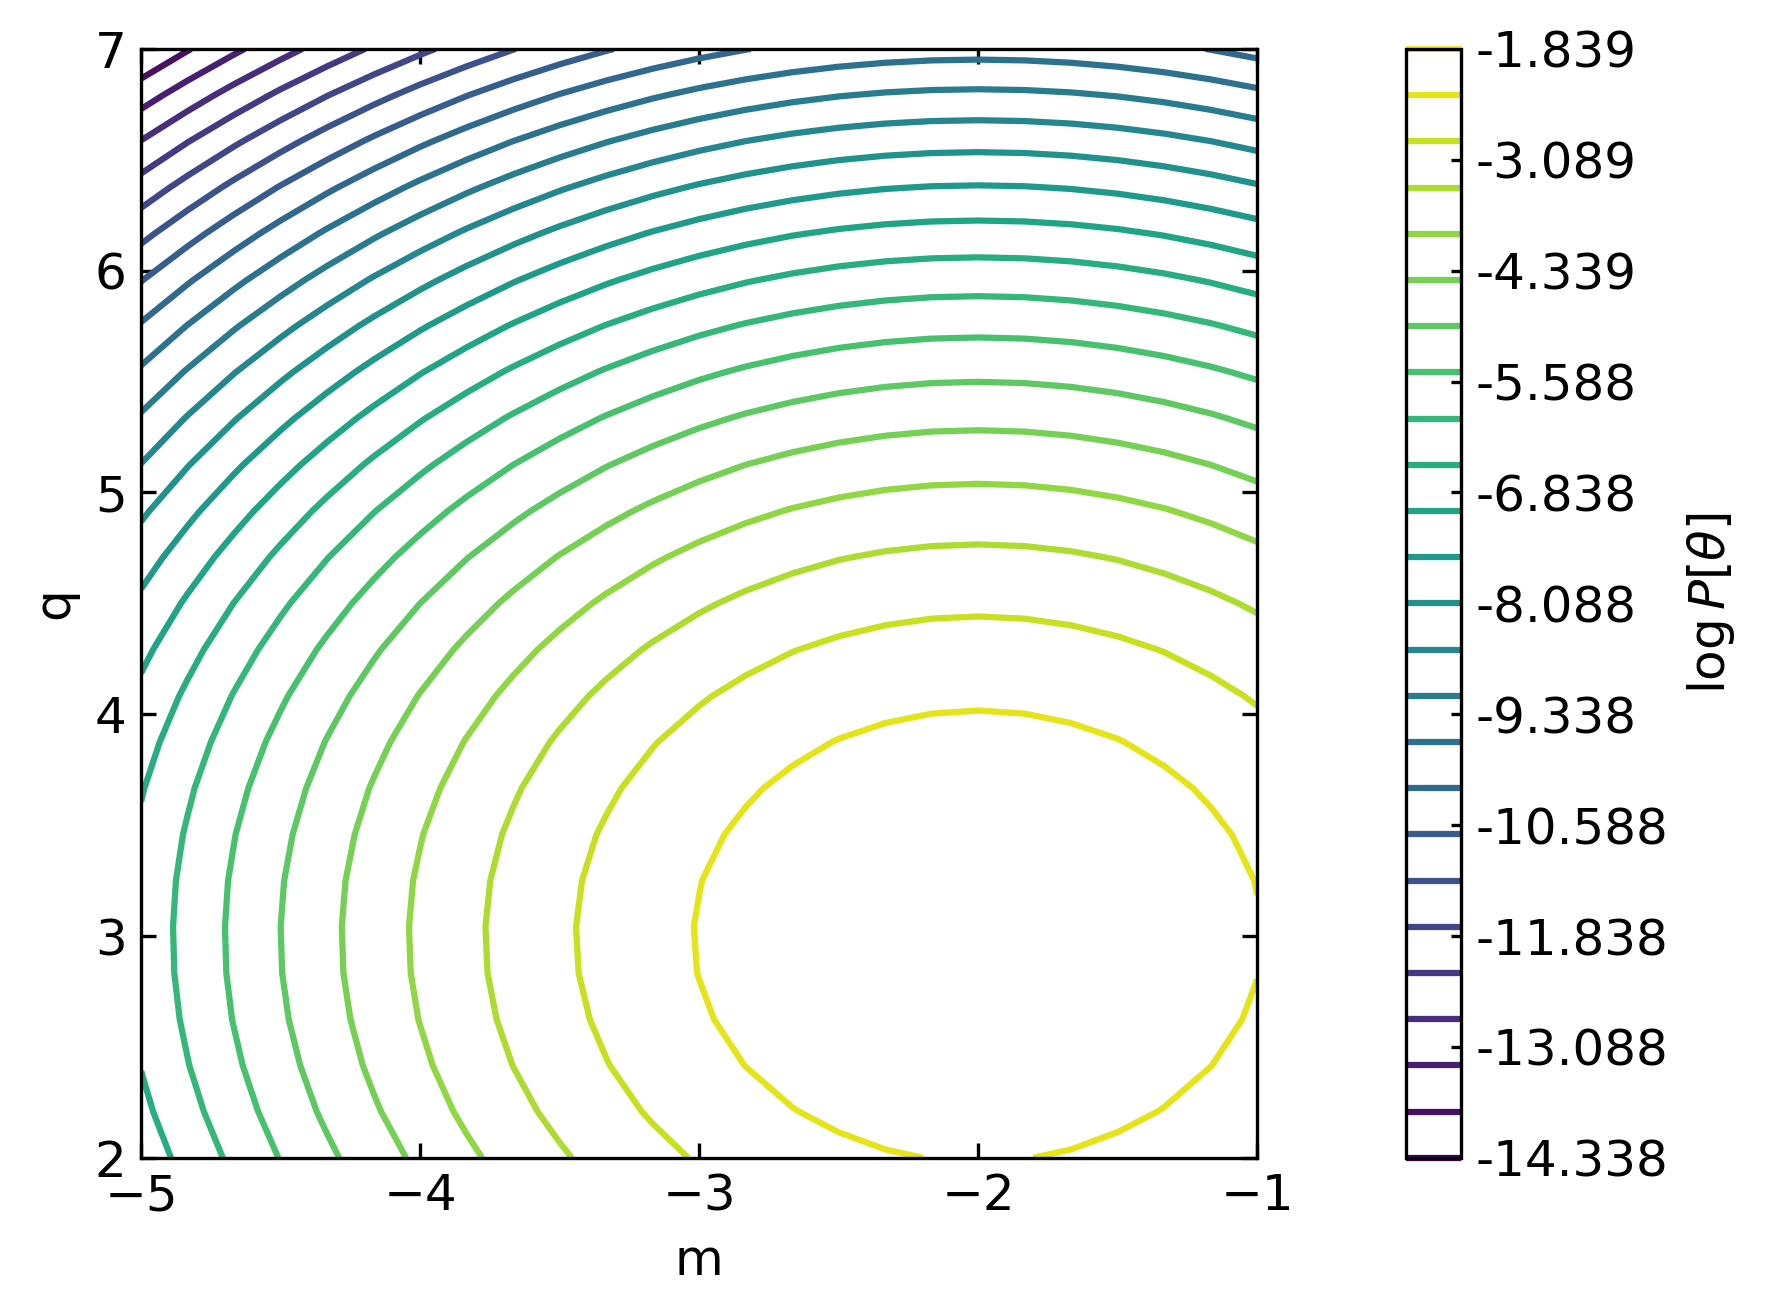

19:49:09 - bfade.viewers - DEBUG - BayesViewer.contour. Contour: log_likelihood
19:51:57 - bfade.util - DEBUG - SHOW PIC: Line-Ref_bay_log_likelihood


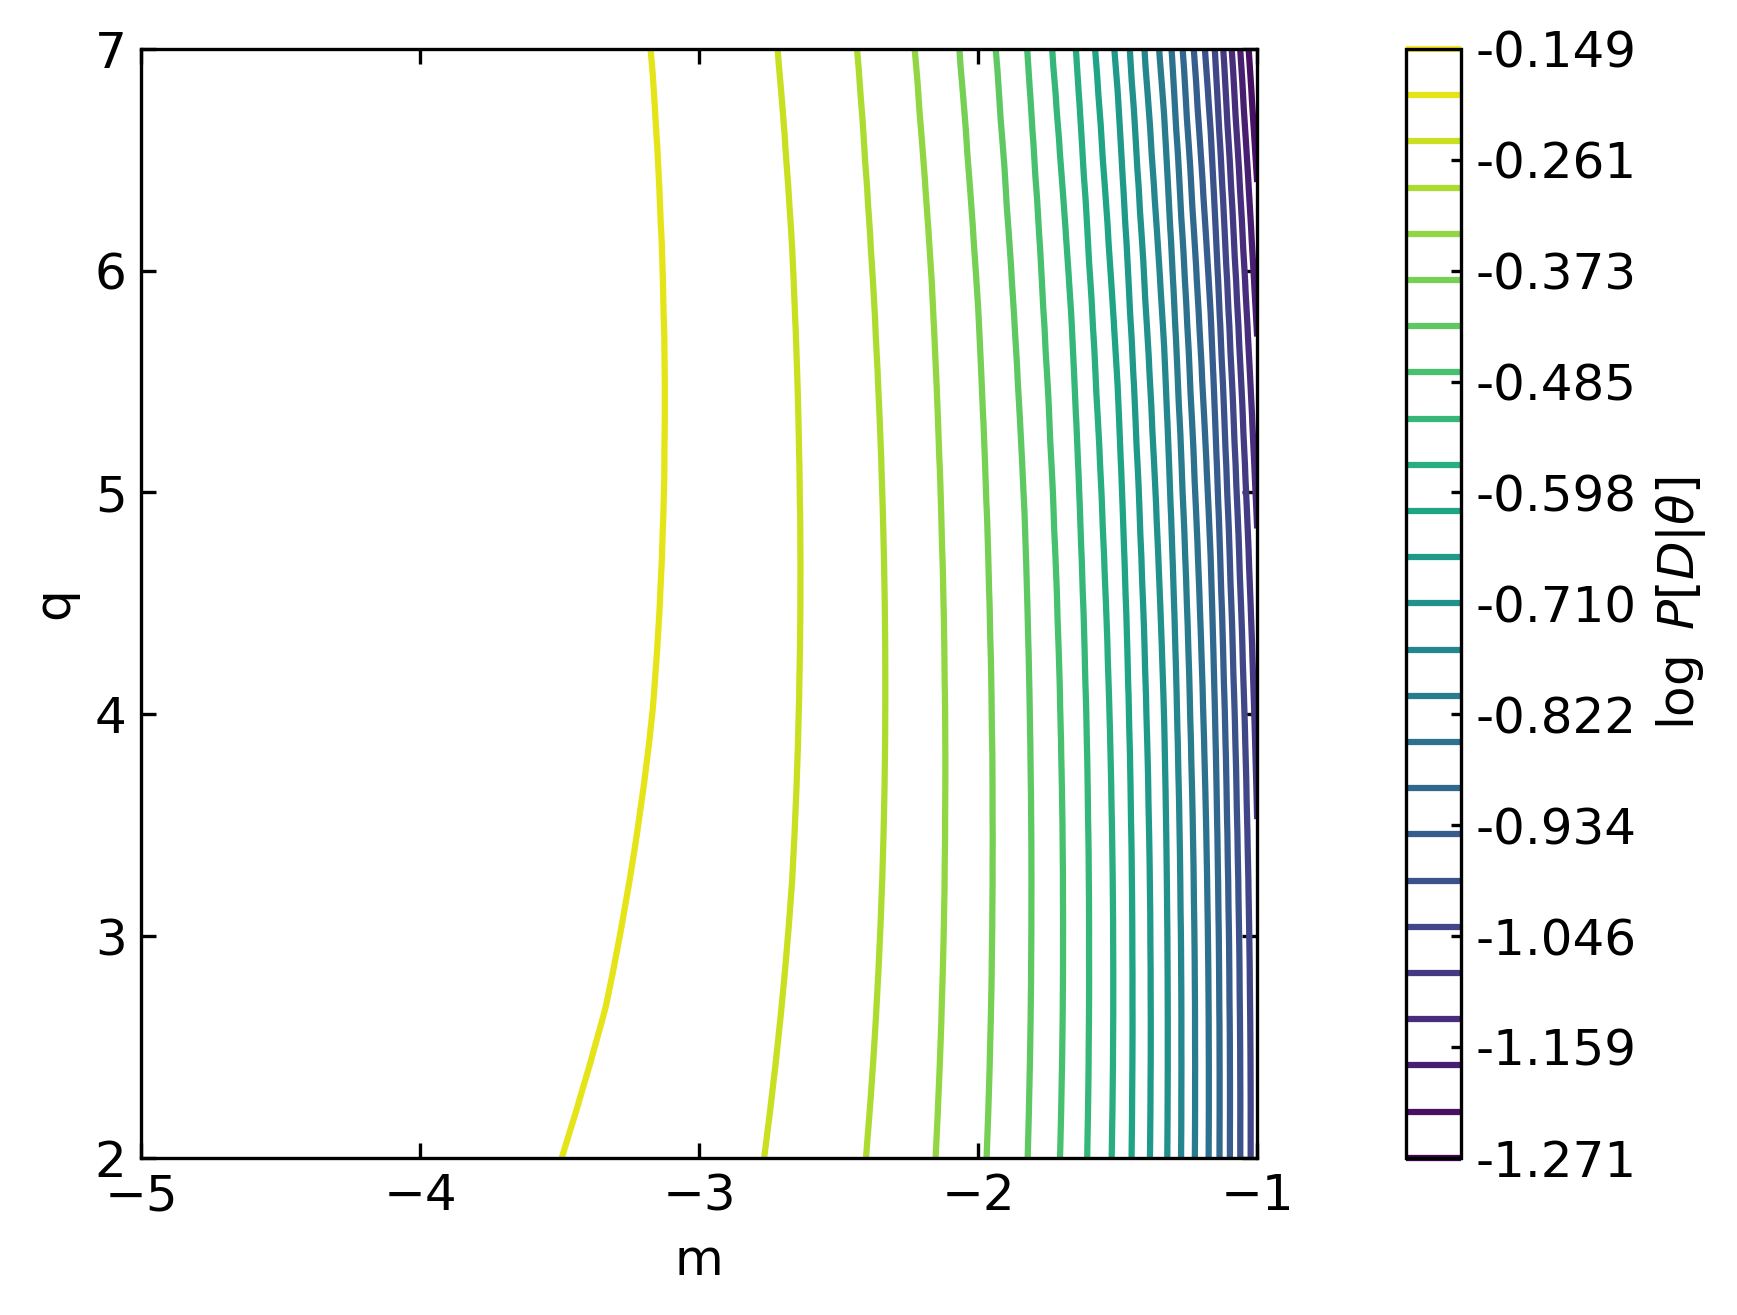

19:51:58 - bfade.viewers - DEBUG - BayesViewer.contour. Contour: log_posterior
19:54:46 - bfade.util - DEBUG - SHOW PIC: Line-Ref_bay_log_posterior


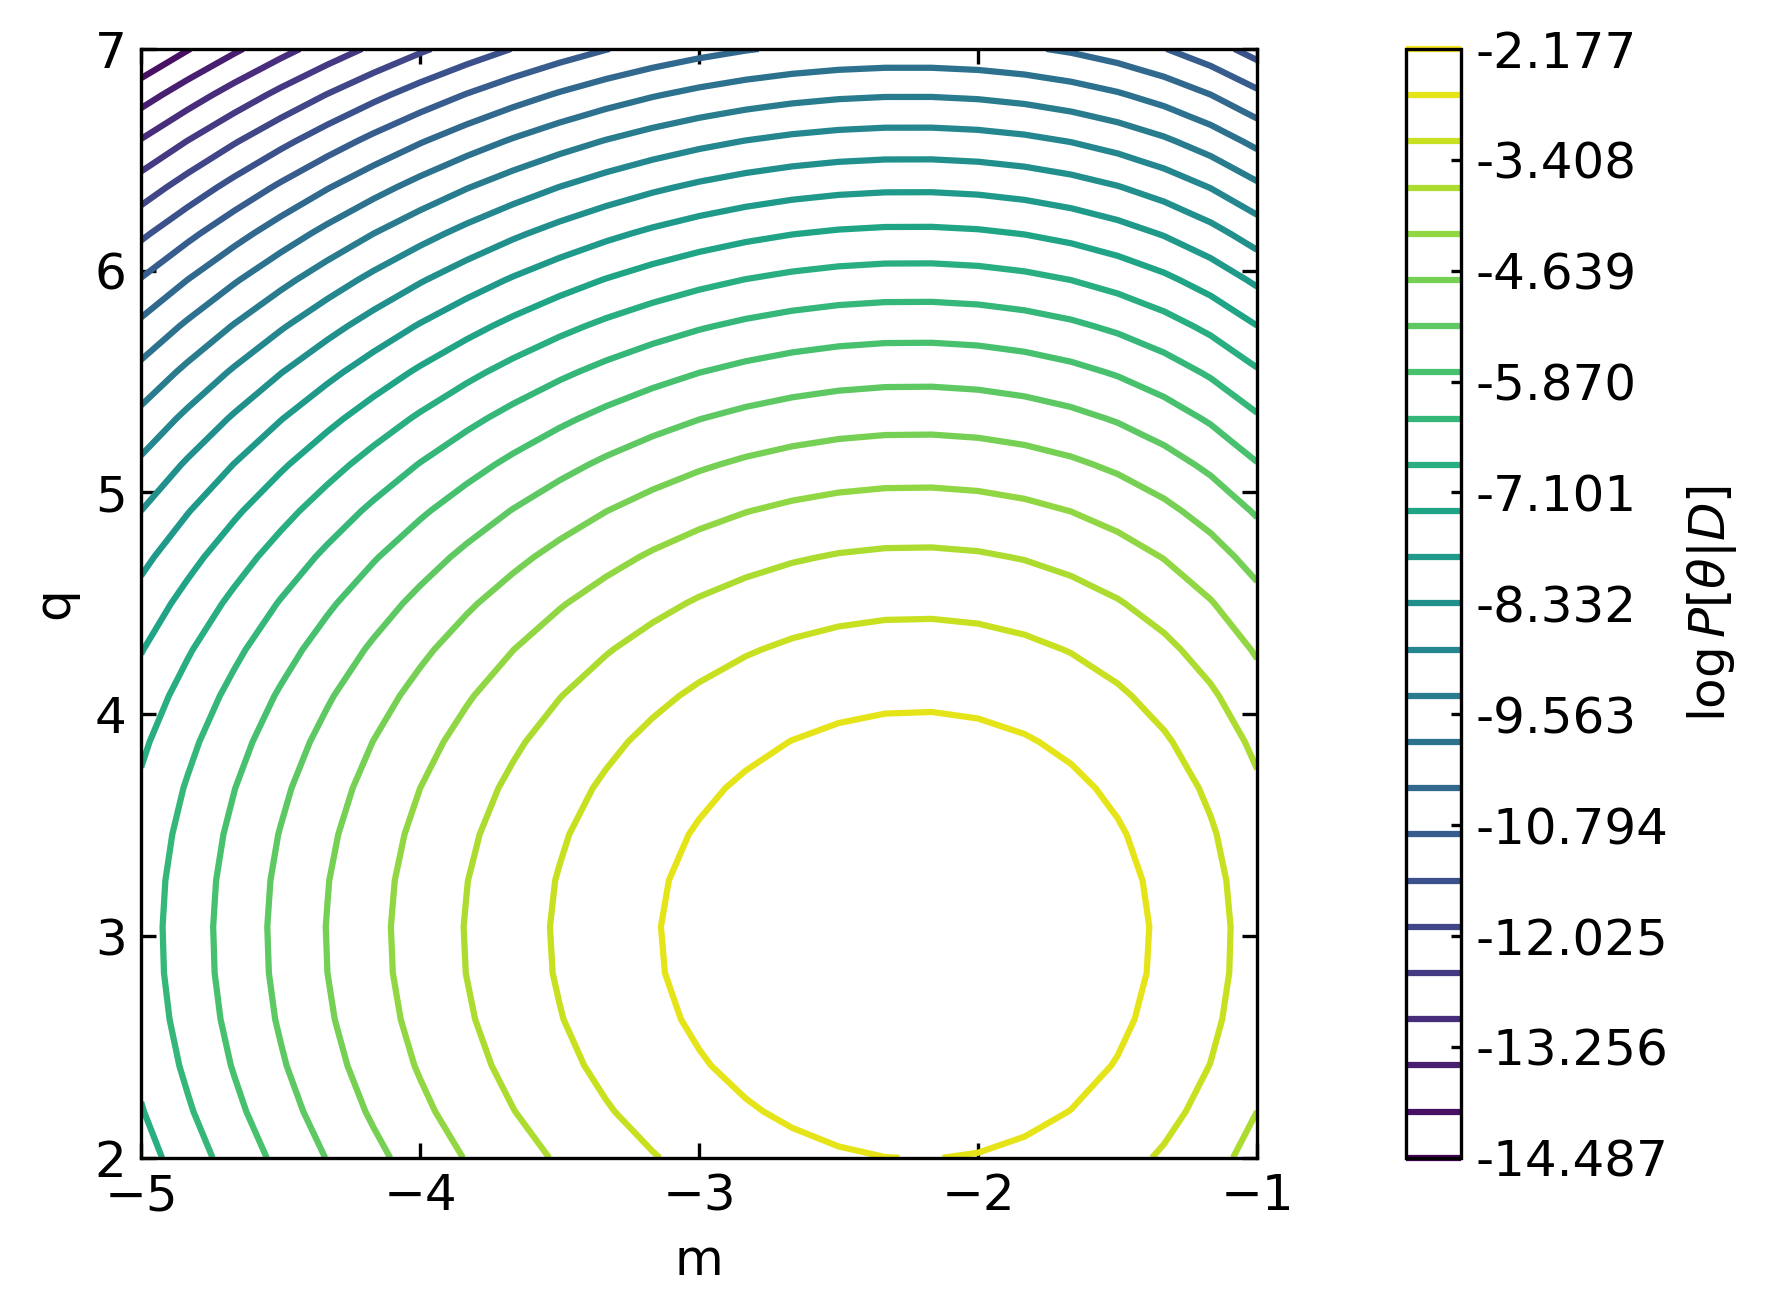

In [15]:
# Initialise BayesViewer and pre-inference inspection
nv = BayesViewer("m", m_bounds, m_points,
                 "q", q_bounds, q_points, name=line_name)
nv.config_contour(levels=25)
nv.contour("log_prior", nbay)
nv.contour("log_likelihood", nbay, nd)
nv.contour("log_posterior", nbay, nd)

Due to noisy data, the maximum of the `log_likelihood` is little far from the reference parameters. Conversely, the `log_posterior` foreshadows a maximum around the reference parameters, thanks to the injection of the prior knowledge (`log_prior`), reasonably. Now MAP is executed.

In [16]:
nbay.MAP(nd, guess)

19:54:46 - bfade.abstract - INFO - LineBayes.MAP -- Default solver Nelder-Mead, {'disp': True, 'maxiter': 10000000000.0}
19:54:46 - bfade.abstract - WARNING - LineBayes.MAP -- Run MAP.
19:54:48 - bfade.abstract - INFO - Iter: 0 -- Params: [-1.075  1.075] -- Min 5.092
19:54:48 - bfade.abstract - INFO - Iter: 1 -- Params: [-1.1875  1.0125] -- Min 4.989
19:54:49 - bfade.abstract - INFO - Iter: 2 -- Params: [-1.29375  1.13125] -- Min 4.576
19:54:50 - bfade.abstract - INFO - Iter: 3 -- Params: [-1.571875  1.065625] -- Min 4.352
19:54:51 - bfade.abstract - INFO - Iter: 4 -- Params: [-1.9234375  1.2703125] -- Min 3.741
19:54:51 - bfade.abstract - INFO - Iter: 5 -- Params: [-1.9234375  1.2703125] -- Min 3.741
19:54:52 - bfade.abstract - INFO - Iter: 6 -- Params: [-2.553125  1.409375] -- Min 3.529
19:54:53 - bfade.abstract - INFO - Iter: 7 -- Params: [-2.31171875  1.61015625] -- Min 3.160
19:54:54 - bfade.abstract - INFO - Iter: 8 -- Params: [-2.31171875  1.61015625] -- Min 3.160
19:54:54 - bfa

Optimization terminated successfully.
         Current function value: 2.175594
         Iterations: 46
         Function evaluations: 87


19:55:54 - bfade.abstract - DEBUG - LineBayes.laplace_posterior -- Load distributions.
19:55:54 - bfade.abstract - WARNING - LineBayes.MAP -- theta_hat [-2.20943185  3.00470785]
19:55:54 - bfade.abstract - WARNING - LineBayes.MAP -- ihess [[ 0.78158446 -0.00457239]
 [-0.00457239  0.99475148]]


### Laplace Posterior
Once MAP is accomplished, it is possible to display the approximated Laplace posterior. To do so the user is required to instantiate a specific viewer, i.e. `LaplacePosteriorViewer`.

19:55:54 - bfade.viewers - DEBUG - LaplacePosteriorViewer.__init__
19:55:54 - bfade.abstract - DEBUG - LaplacePosteriorViewer.__init__ -- LaplacePosteriorViewer(c1 = 4,
 c2 = 4,
 name = Untitled,
 pars = ('m', 'q'),
 p1 = m,
 p2 = q,
 n1 = 100,
 n2 = 100,
 b1 = [-5.74572248  1.32685878],
 b2 = [-0.98478129  6.994197  ],
 spacing = lin,
 bounds_m = [-5.74572248  1.32685878],
 bounds_q = [-0.98478129  6.994197  ])
19:55:54 - bfade.abstract - DEBUG - LaplacePosteriorViewer.config
19:55:54 - bfade.abstract - DEBUG - LaplacePosteriorViewer.config_contour
19:55:54 - bfade.viewers - DEBUG - LaplacePosteriorViewer.contour -- joint poterior
19:55:55 - bfade.util - DEBUG - SHOW PIC: Untitled_laplace_joint


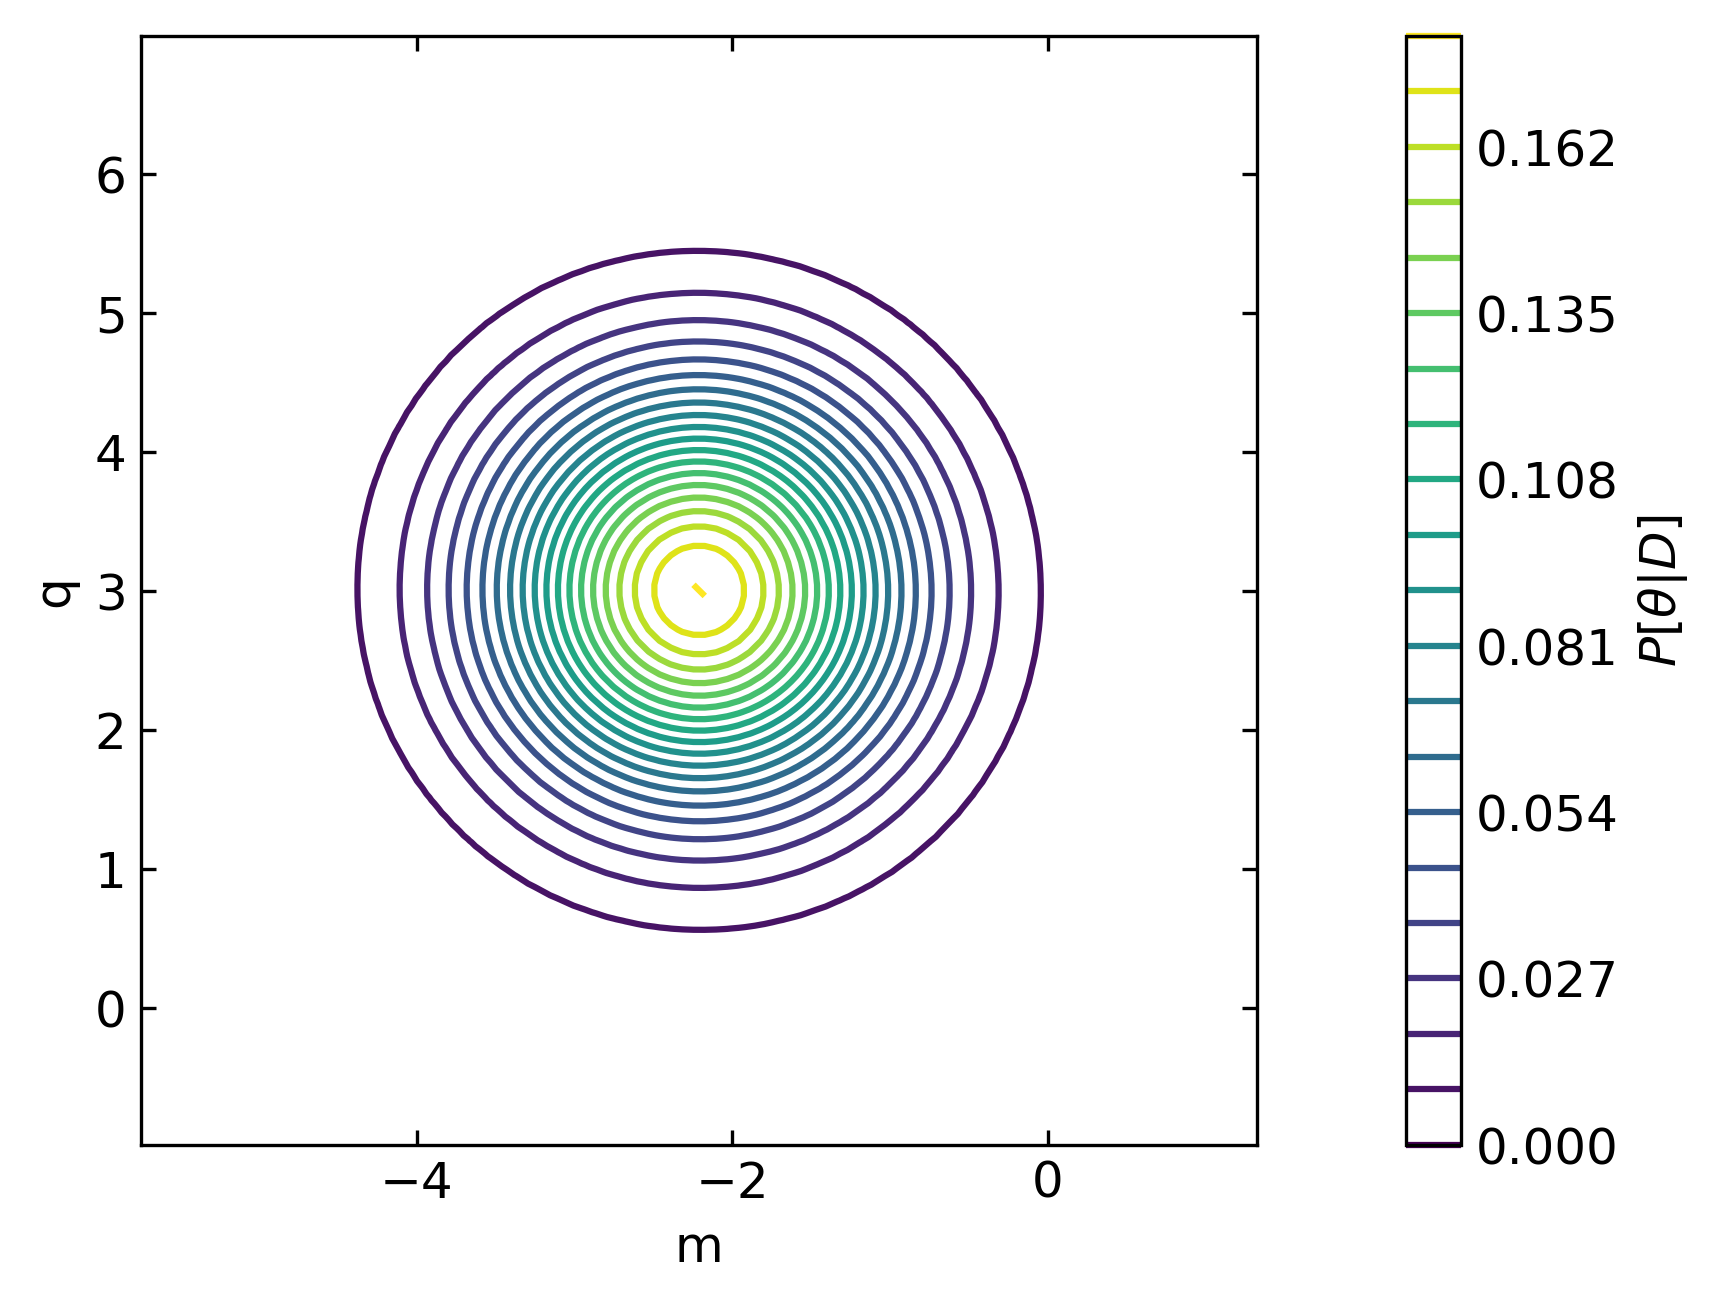

19:55:55 - bfade.viewers - DEBUG - LaplacePosteriorViewer.marginals
19:55:55 - bfade.util - DEBUG - SHOW PIC: Untitled_lap_marginal_m


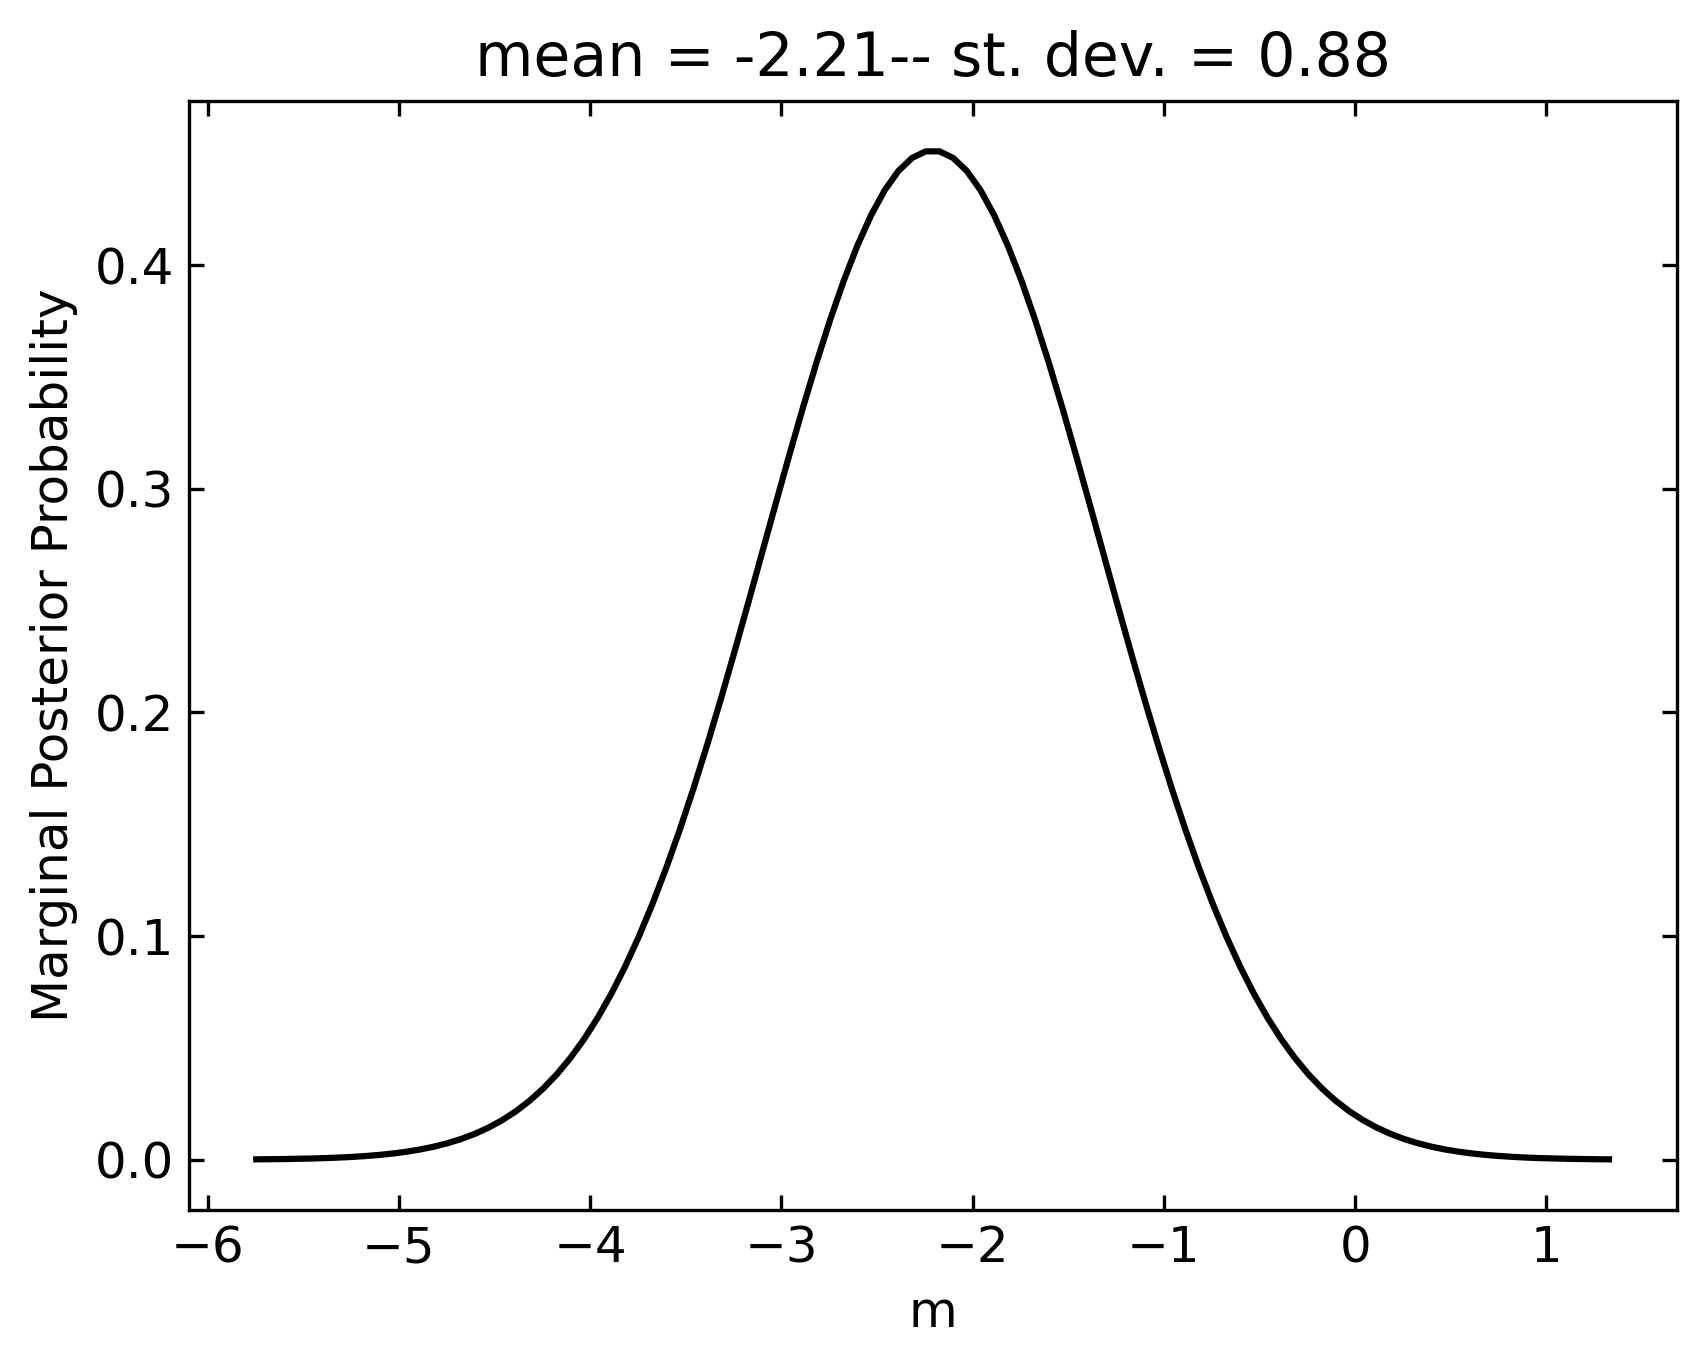

19:55:55 - bfade.viewers - DEBUG - LaplacePosteriorViewer.marginals
19:55:55 - bfade.util - DEBUG - SHOW PIC: Untitled_lap_marginal_q


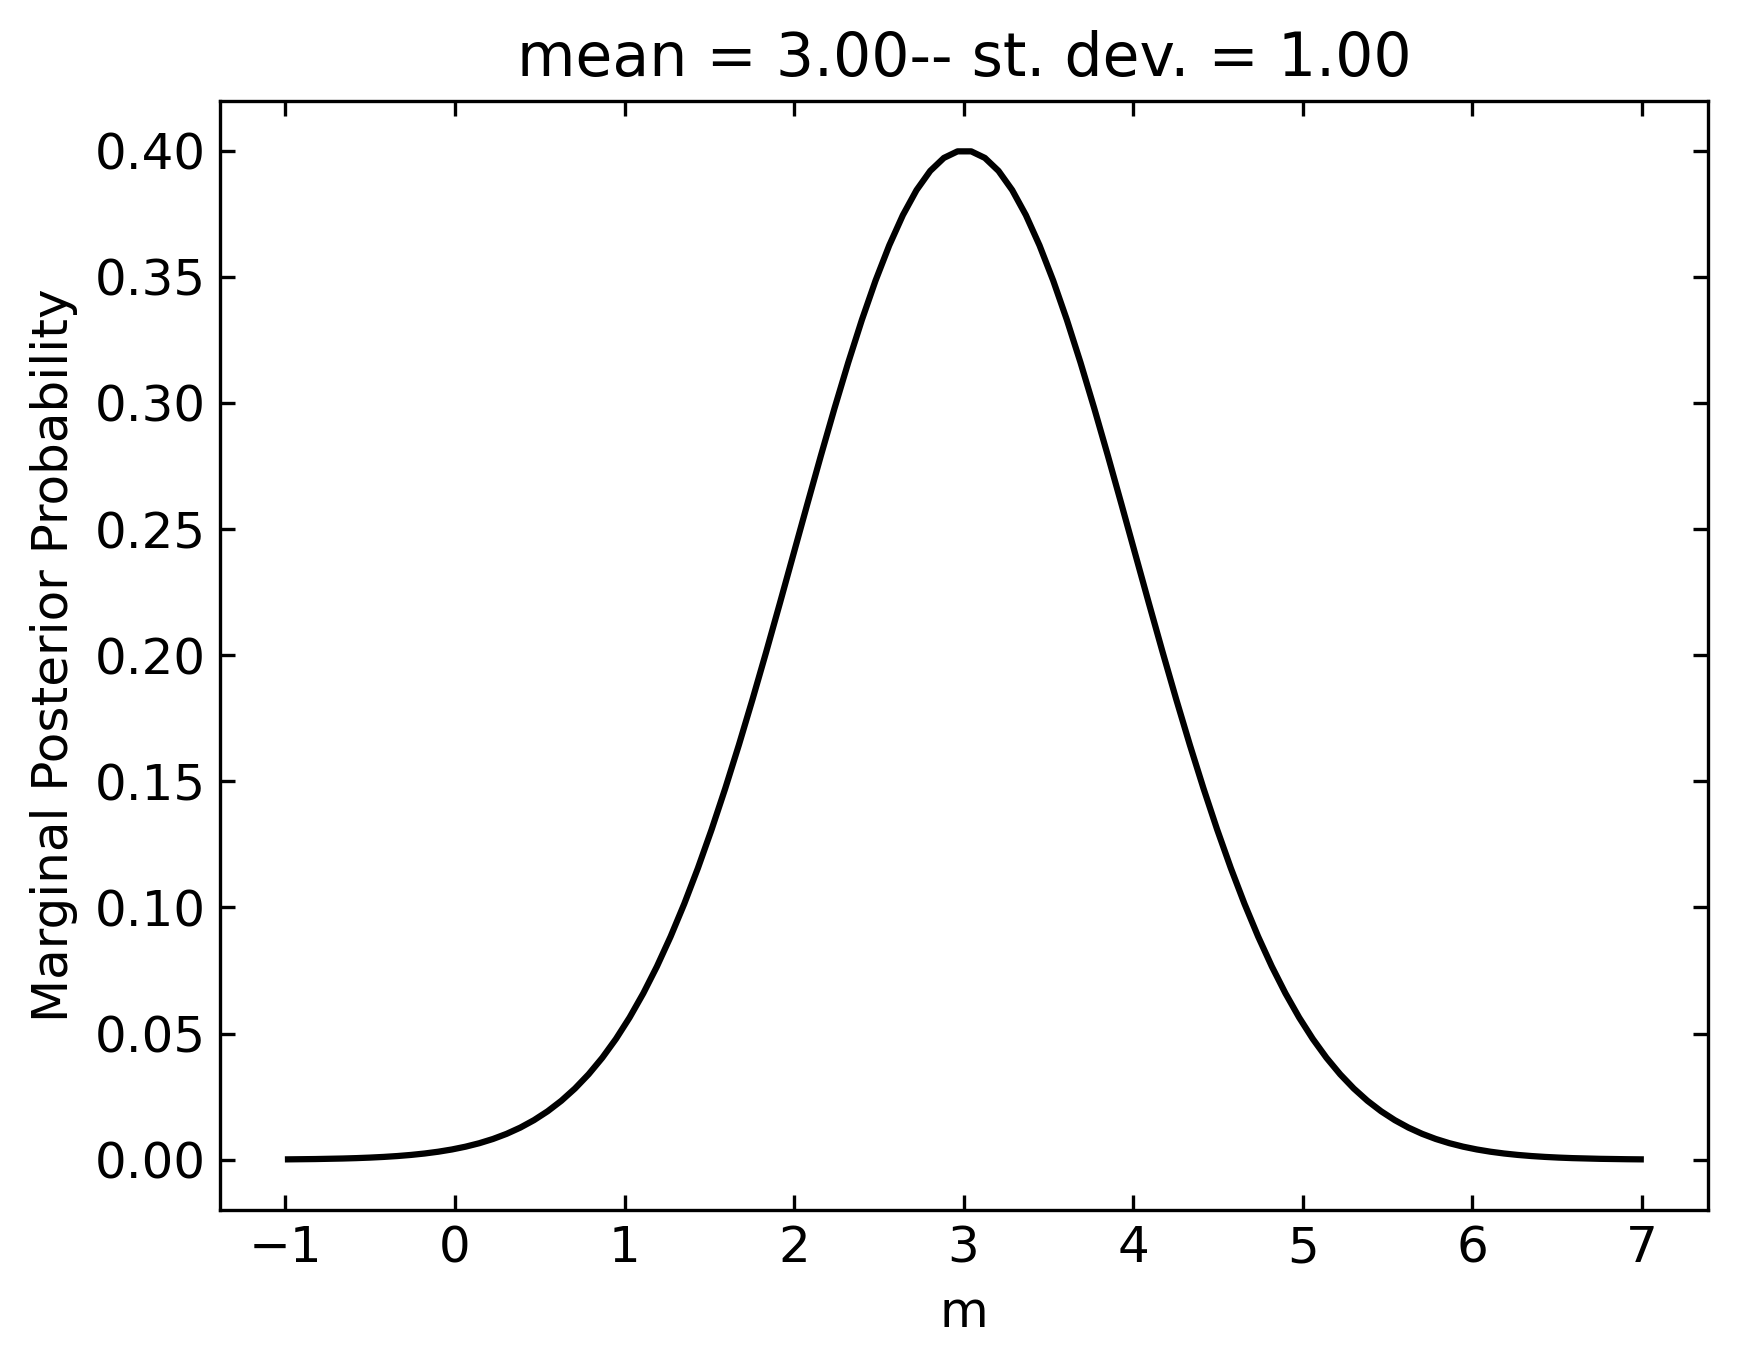

In [17]:
nl = LaplacePosteriorViewer("m", m_n_std, m_n_points, 
                           "q",  q_n_std,  q_n_points, nbay)
nl.contour(nbay) # plot joint distribution
nl.marginals("m", nbay) # plot marginal distribution m
nl.marginals("q", nbay) # plot marginal distribution of q

### Results
Our MAP estimates is still close to the reference values. Yet some deviation should be expected as MAP found a trade off between data (`log-likelihood`) and prior knowledge (`log_prior`). As shown earlier, we shall extract the estimated (optimal) parameters from and define the expected (optimal) line that partition the dataset. Next, we instantiate a `PreProViewer` to inspect the results, along with the training dataset. In this case, the predictive posterior, and therefore, the computation of prediction bands, are available.

Furthermore, we instantiate a `MonteCarlo` object to compute the prediction intervals for the estimated EH curve. In this regard, we do not run explicitly a Monte Carlo simulation, but we rely on the interface of PreProViewer to trigger the computations. Similarly, the predictive posterior is not directly computed, though the computation are triggered via the interface of the viewer.

As for the predictive posterior, an evaluation grid is required. We generate a regular log-spaced grid of points

19:55:55 - bfade.viewers - DEBUG - PreProViewer.__init__ -- PreProViewer(x_edges = [-15, 15],
 y_edges = [-10, 10],
 x_scale = linear,
 y_scale = linear,
 n = 1000,
 name = Line-Ref,
 det_pars = {})
19:55:55 - bfade.viewers - DEBUG - PreProViewer.config
19:55:55 - bfade.viewers - DEBUG - PreProViewer.config_canvas
19:55:55 - bfade.statistics - DEBUG - MonteCarlo.__init__
19:55:55 - bfade.dataset - DEBUG - SyntheticDataset.config
19:55:55 - bfade.dataset - DEBUG - SyntheticDataset.make_grid
19:55:55 - bfade.viewers - INFO - Inspect training data
19:55:55 - bfade.viewers - DEBUG - PreProViewer.add_colourbar
19:55:55 - bfade.viewers - DEBUG - State: Line-Ref_train
19:55:55 - bfade.viewers - INFO - Inspect given curves
19:55:55 - bfade.viewers - DEBUG - State: Line-Ref_train_Untitled
19:55:55 - bfade.viewers - DEBUG - State: Line-Ref_train_Untitled_Line-Ref-Estimated
19:55:55 - bfade.viewers - INFO - Inspect prediction interval
19:55:55 - bfade.statistics - DEBUG - MonteCarlo.sample -- Joi

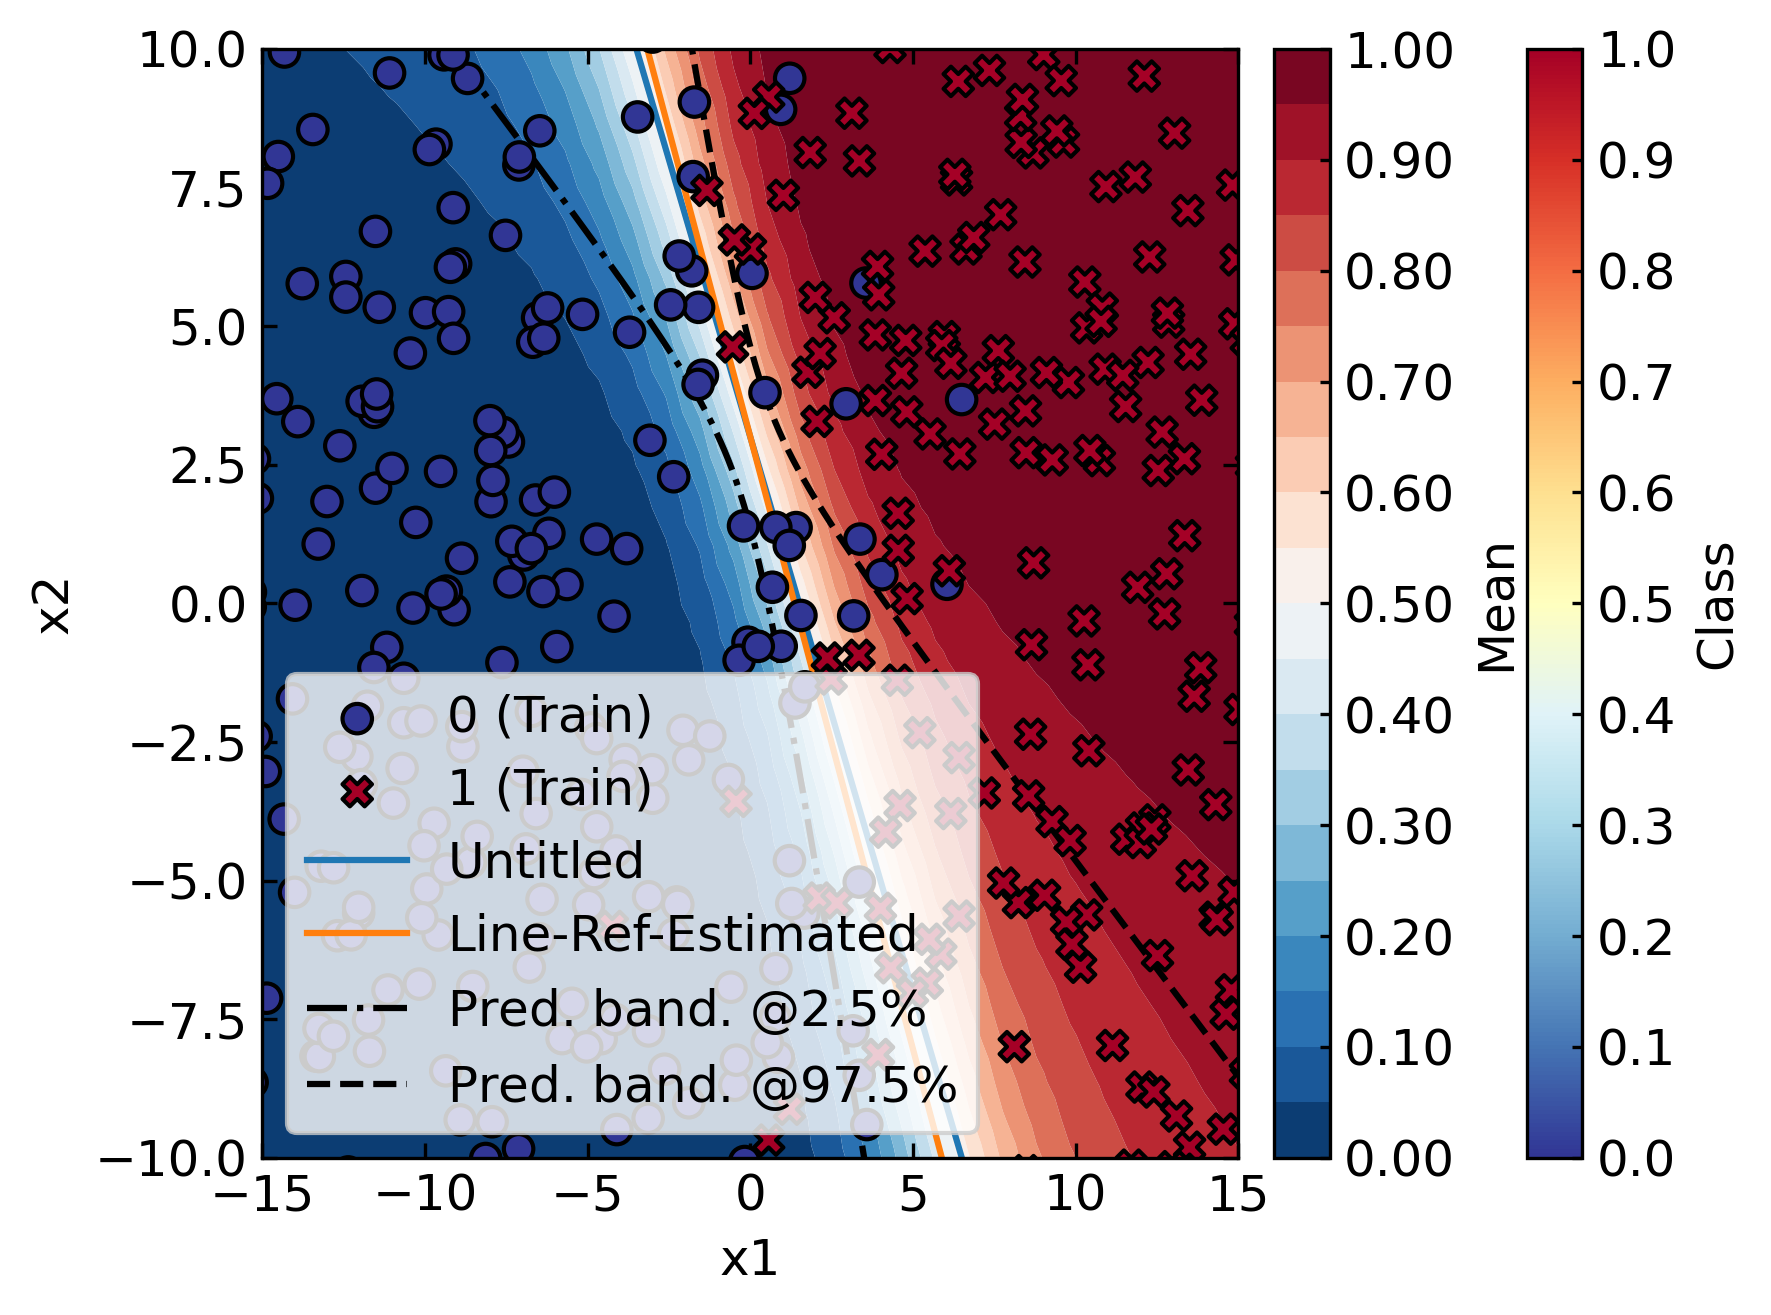

19:56:15 - bfade.viewers - INFO - Inspect training data
19:56:15 - bfade.viewers - DEBUG - PreProViewer.add_colourbar
19:56:15 - bfade.viewers - DEBUG - State: Line-Ref_train
19:56:15 - bfade.viewers - INFO - Inspect given curves
19:56:15 - bfade.viewers - DEBUG - State: Line-Ref_train_Untitled
19:56:15 - bfade.viewers - DEBUG - State: Line-Ref_train_Untitled_Line-Ref-Estimated
19:56:15 - bfade.viewers - INFO - Inspect prediction interval
19:56:15 - bfade.statistics - DEBUG - MonteCarlo.sample -- Joint, samples = 10000
19:56:15 - bfade.statistics - INFO - MonteCarlo.prediction_interval -- Confidence = 0.95%
19:56:15 - bfade.viewers - DEBUG - State: Line-Ref_train_Untitled_Line-Ref-Estimated_pi
19:56:15 - bfade.viewers - INFO - Inspect predictive posterior
19:56:15 - bfade.abstract - DEBUG - LineBayes.predictive_posterior
19:56:34 - bfade.abstract - DEBUG - LineBayes.predictive_posterior -- Return prediction stack
19:56:34 - bfade.viewers - DEBUG - State: Line-Ref_train_Untitled_Line-Re

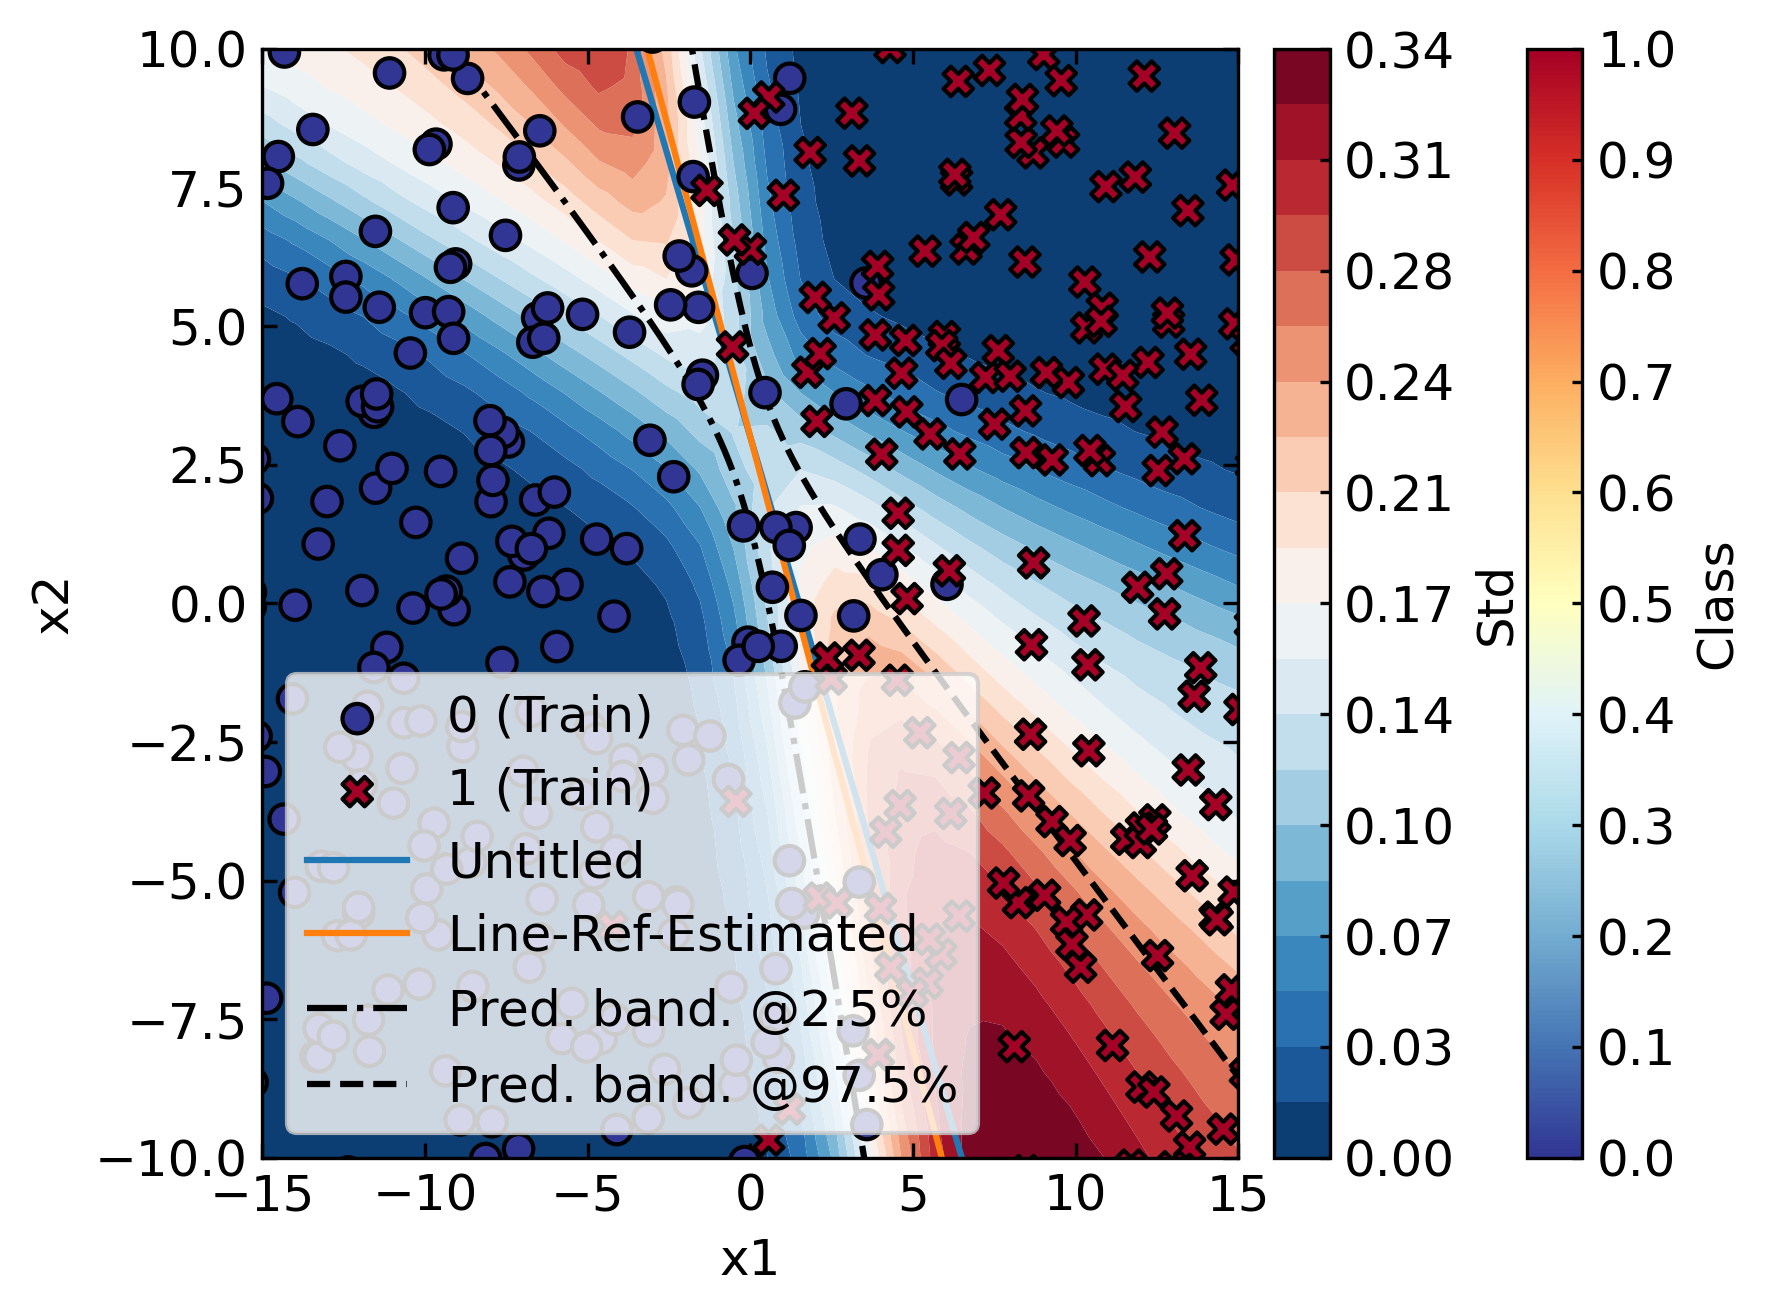

In [18]:
# Retrieve the estimated EH curve through MLE (MAP)
optn = Line(m=nbay.theta_hat[0], q=nbay.theta_hat[1], name=line_name + "-Estimated")

# Instantiate the viewer
ppn = PreProViewer(x1_bounds, x2_bounds, line_res_points, scale=data_scale, name=line_name)

# Instantiate MonteCarlo object to probe ElHaddadCurve (for prediction bands)
mc = MonteCarlo(Line)

# Create regular log-spaced grid to evaluate the predictive posterior
eval_grid = SyntheticDataset(name=line_name + "_Eval")
eval_grid.make_grid(x1_bounds_post, x2_bounds_post,
                    x1_points_post, x2_points_post, spacing="lin")

ppn.view(train_data=nd, curve=[l, optn], # pass eval grid as train data along with the curves to plot
       prediction_interval=mc,
       mc_bayes=nbay,
       mc_samples=monte_carlo_samples,
       mc_distribution=monte_carlo_sampling,
       confidence=confidence_level,
       predictive_posterior=nbay,
       post_samples=posterior_samples,
       post_op=post_op_1, # mean
       post_data=eval_grid
       )

ppn.view(train_data=nd, curve=[l, optn], # pass eval grid as train data along with the curves to plot
       prediction_interval=mc,
       mc_bayes=nbay,
       mc_samples=monte_carlo_samples,
       mc_distribution=monte_carlo_sampling,
       confidence=confidence_level,
       predictive_posterior=nbay,
       post_samples=posterior_samples,
       post_op=post_op_2, #std
       post_data=eval_grid)